In [ ]:
# Installing missing libraries
!pip install datasets
!pip install gensim
!pip install seqeval
!pip install torch

## Importing Relevant Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import gensim
import gensim.downloader as api
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from datasets import load_dataset
from collections import Counter
from itertools import product

In [4]:
# Load Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [5]:
# Checking whether cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {'GPU' if device.type == 'cuda' else 'CPU'}.")

Using GPU.


# Part 2. Model Training & Evaluation RNN


## Dataset Preparation (derivations from Part 1)


In [5]:
# Function to preprocess the text
def preprocess_text(text):
    return simple_preprocess(text, deacc=True)  # deacc = True -> remove accent marks e.g. café to cafe

# Preprocess the training dataset
train_tokens = [preprocess_text(example['text']) for example in train_dataset]

# Iterate through the train dataset tokens and get the unique words to build vocabulary
vocab_counter = Counter([word for tokens in train_tokens for word in tokens])
train_vocab = list(vocab_counter.keys())

# File Path to directory to store the pre-defined models (change as necessary)
model_dir_path = "models"

# Load the glove-wiki-gigaword-200 vectors from the .vec file
glove_model = KeyedVectors.load(os.path.join(model_dir_path, "glove-wiki-gigaword-300.model"), mmap='r')

# Create the embedding matrix from the pre-traind gloVe model
embedding_matrix = np.array(glove_model.vectors)

## Define the SentimentDataset Class and Collate Function

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Convert each token in the sentence to its corresponding index, 0 for unknown words
        tokens = self.texts[idx].split()
        embedding_indices = [self.vocab.get(word, 0) for word in tokens]
        label = self.labels[idx]

        # Skip any sequences that are effectively empty
        if len(embedding_indices) == 0 or all(index == 0 for index in embedding_indices):
            return None
        return torch.tensor(embedding_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)


def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None, None

    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=0)  # Pad sequences with 0
    labels = torch.stack(labels)
    return texts, labels


## Prepare datasets for dataloader

In [7]:
# Replace these with actual dataset texts and labels
train_texts = train_dataset['text']
train_labels = train_dataset['label']
val_texts = validation_dataset['text']
val_labels = validation_dataset['label']
test_texts = test_dataset['text']
test_labels = test_dataset['label']

# Create vocabulary to index mapping (from Part 1)
vocab_to_index = {word: idx for idx, word in enumerate(train_vocab)}

# Instantiate datasets
train_data = SentimentDataset(train_texts, train_labels, vocab_to_index)
val_data = SentimentDataset(val_texts, val_labels, vocab_to_index)
test_data = SentimentDataset(test_texts, test_labels, vocab_to_index)

## RNN Models

## Define RNN Model

In [8]:
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, pooling_strategy, dropout=0.5):
        super(SentimentRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.pooling_strategy = pooling_strategy

    def forward(self, text):
        lengths = (text != 0).sum(dim=1)
        lengths, perm_idx = lengths.sort(0, descending=True)
        text = text[perm_idx]

        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)

        packed_output, hidden = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Apply the selected pooling strategy
        if self.pooling_strategy == 'last':
            hidden = hidden.squeeze(0)
            sentence_representation = hidden[perm_idx.argsort()]
        elif self.pooling_strategy == 'max':
            sentence_representation, _ = torch.max(output, dim=1)
        elif self.pooling_strategy == 'mean':
            sentence_representation = torch.mean(output, dim=1)
        elif self.pooling_strategy == 'max + mean':
            max_pooled, _ = torch.max(output, dim=1)
            mean_pooled = torch.mean(output, dim=1)
            sentence_representation = (max_pooled + mean_pooled) / 2

        # Pass through the fully connected layer
        sentence_representation = self.dropout(sentence_representation)
        return self.fc(sentence_representation)


## Training and Evaluation Helper Functions

In [29]:
# Function to save model
def save_model(model, model_save_path):
    try:
        # Save the model directly (it overwrites the file if it exists)
        torch.save(model.state_dict(), model_save_path)
        print("Model saved.")
    except Exception as e:
        print(f"Failed to save model to {model_save_path}: {e}")

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for texts, labels in loader:
        # Skip empty batches
        if texts is None or labels is None:
            continue
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for texts, labels in loader:
          # Skip empty batches
          if texts is None or labels is None:
              continue
          outputs = model(texts)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(loader), total_correct / len(loader.dataset)

# Function for the whole model training and evaluation process
def train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    early_stopping_patience=10,
    pooling_strategy=None,
    load_best_model=False
):
    print(f"Training with pooling strategy: {pooling_strategy}")

    # Ensure the model uses the correct pooling strategy
    model.pooling_strategy = pooling_strategy

    best_val_accuracy = 0
    no_improve_epochs = 0

    # Initialising Data Structures
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Train the model within specified number of epochs
    for epoch in range(epochs):

        train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)

        # Append values to list
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Early stopping logic
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve_epochs = 0
            save_model(model, os.path.join(os.getcwd(), f'best_model_{pooling_strategy}.pt'))
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs.")
            if no_improve_epochs >= early_stopping_patience:
                print(f"Early stopping triggered at epoch {epoch+1} due to no improvement.")
                break
    
    # Load the best model
    if load_best_model:
        path = os.path.join(os.getcwd(), f'best_model_{pooling_strategy}.pt')
        with open(path, 'rb') as f:
            model.load_state_dict(torch.load(f))
        print("Best Model Loaded.")

    return train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies

In [10]:
# Function to create the plots for analysis
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker = 'o', color = 'blue')
    plt.plot(epochs, test_losses, label='Test Loss', marker = 'o', color = 'green')
    plt.plot(epochs, val_losses, label='Validation Loss', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker = 'o', color = 'blue')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', marker = 'o', color = 'green')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker = 'o', color = 'red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## GridSearchCV

In [30]:
def grid_search_train_and_evaluate(param_grid, model, criterion, pooling_strategy, epochs, early_stopping_patience):
    results = []
    best_val_accuracy = 0
    best_config = None

    # Generate all combinations of hyperparameters
    hyperparameter_combinations = list(product(*param_grid.values()))

    for params in hyperparameter_combinations:
        learning_rate, batch_size, optimizer_name = params

        print(f"\nTraining with parameters: Learning Rate={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}")

        # Initialize data loaders
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)
        val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)

        # Set up the optimizer based on the current config
        if optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'Adagrad':
            optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        elif optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        # Train and evaluate the model
        train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(model,
                                                                                                                      train_loader,
                                                                                                                      test_loader,
                                                                                                                      val_loader,
                                                                                                                      optimizer,
                                                                                                                      criterion,
                                                                                                                      epochs=epochs,
                                                                                                                      early_stopping_patience=early_stopping_patience,
                                                                                                                      pooling_strategy=pooling_strategy)


        # Plot accuracy and loss for the current configuration
        plt.figure(figsize=(14, 7))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss - LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}')
        plt.legend()
        plt.grid(True)

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Val Accuracy')
        plt.plot(test_accuracies, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy - LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Save simplified results
        best_val_acc_for_config = max(val_accuracies)
        final_test_acc_for_config = test_accuracies[-1]
        results.append({
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'optimizer': optimizer_name,
            'best_val_accuracy': best_val_acc_for_config,
            'final_test_accuracy': final_test_acc_for_config
        })

        # Check if current configuration is the best so far
        if best_val_acc_for_config > best_val_accuracy:
            best_val_accuracy = best_val_acc_for_config
            best_config = {
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'optimizer': optimizer_name
            }

    print("\nBest Configuration:")
    print(best_config)
    print("Best Validation Accuracy:", best_val_accuracy)

    return results, best_config


Training with parameters: Learning Rate=0.001, Batch Size=32, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.7030, Train Accuracy: 0.5084
Test Loss: 0.7001, Test Accuracy: 0.4953
Val Loss: 0.6936, Val Accuracy: 0.5084
Model saved.

Epoch 2/100
Train Loss: 0.7045, Train Accuracy: 0.4965
Test Loss: 0.6990, Test Accuracy: 0.4850
Val Loss: 0.6931, Val Accuracy: 0.5094
Model saved.

Epoch 3/100
Train Loss: 0.7006, Train Accuracy: 0.5120
Test Loss: 0.6985, Test Accuracy: 0.4916
Val Loss: 0.6930, Val Accuracy: 0.5084
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.7019, Train Accuracy: 0.5048
Test Loss: 0.6977, Test Accuracy: 0.4887
Val Loss: 0.6928, Val Accuracy: 0.5038
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.7003, Train Accuracy: 0.5054
Test Loss: 0.6974, Test Accuracy: 0.4991
Val Loss: 0.6928, Val Accuracy: 0.5047
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.6976, Train Accuracy: 0.5128
Test Loss: 0.6967, Test Accuracy: 0.5

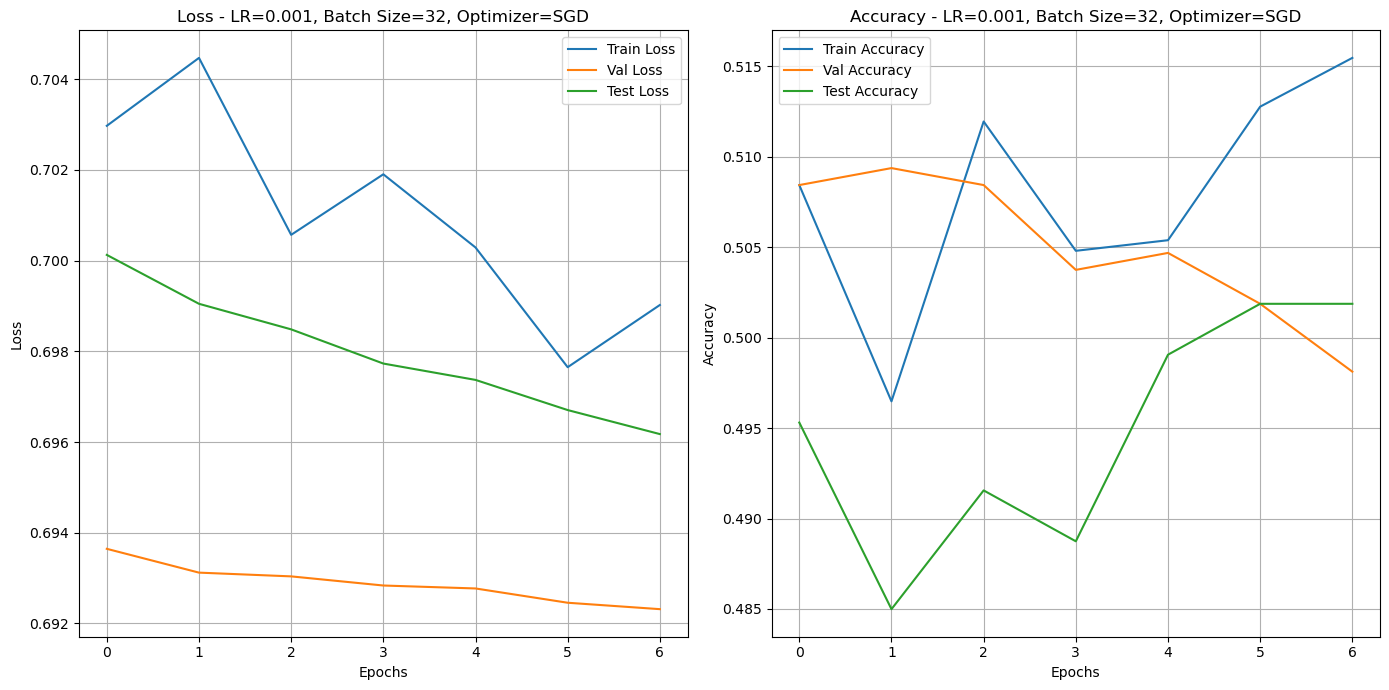


Training with parameters: Learning Rate=0.001, Batch Size=32, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.6946, Train Accuracy: 0.5242
Test Loss: 0.6892, Test Accuracy: 0.5516
Val Loss: 0.6890, Val Accuracy: 0.5197
Model saved.

Epoch 2/100
Train Loss: 0.6876, Train Accuracy: 0.5522
Test Loss: 0.6862, Test Accuracy: 0.5638
Val Loss: 0.6876, Val Accuracy: 0.5197
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.6792, Train Accuracy: 0.5652
Test Loss: 0.6804, Test Accuracy: 0.5854
Val Loss: 0.6848, Val Accuracy: 0.5272
Model saved.

Epoch 4/100
Train Loss: 0.6579, Train Accuracy: 0.6093
Test Loss: 0.6687, Test Accuracy: 0.5826
Val Loss: 0.6798, Val Accuracy: 0.5619
Model saved.

Epoch 5/100
Train Loss: 0.6390, Train Accuracy: 0.6373
Test Loss: 0.6648, Test Accuracy: 0.5919
Val Loss: 0.6756, Val Accuracy: 0.5666
Model saved.

Epoch 6/100
Train Loss: 0.6239, Train Accuracy: 0.6555
Test Loss: 0.6628, Test Accuracy: 0.6004
Val Loss: 0.6779, Val Ac

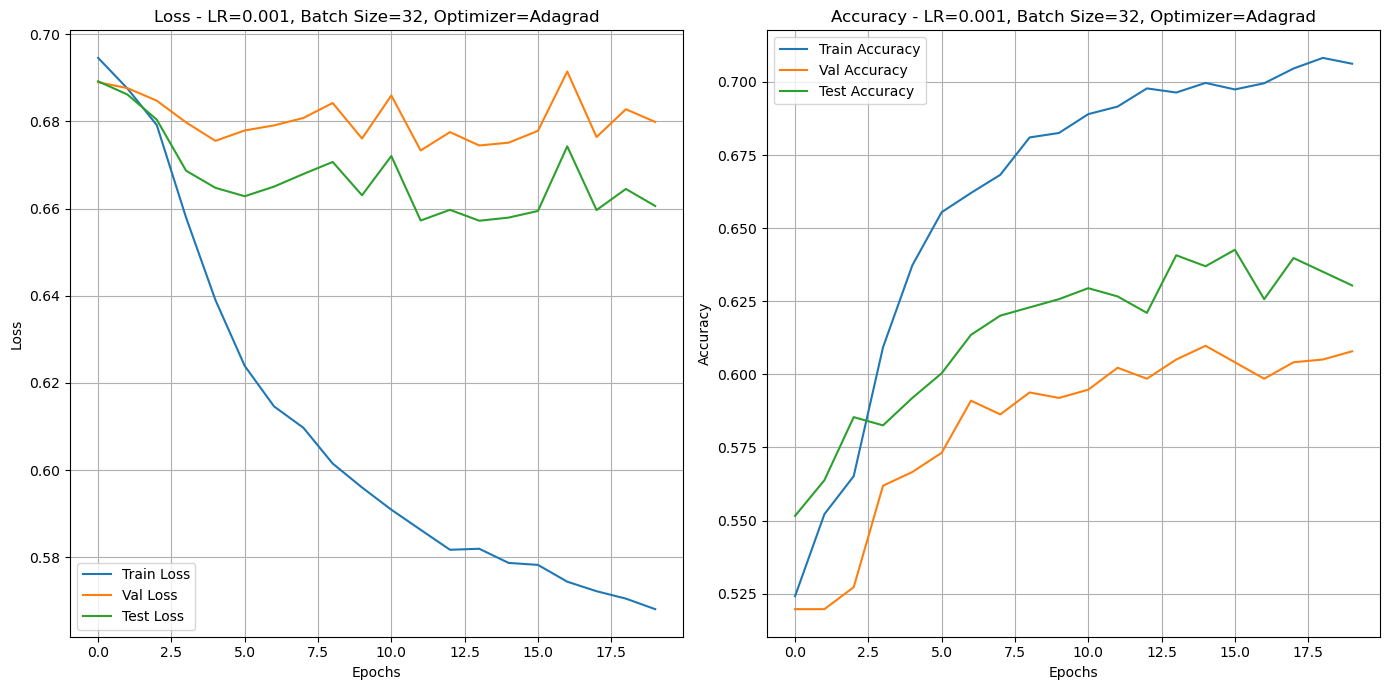


Training with parameters: Learning Rate=0.001, Batch Size=32, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.6541, Train Accuracy: 0.6147
Test Loss: 0.7111, Test Accuracy: 0.5769
Val Loss: 0.7247, Val Accuracy: 0.5563
Model saved.

Epoch 2/100
Train Loss: 0.6198, Train Accuracy: 0.6683
Test Loss: 0.6690, Test Accuracy: 0.5994
Val Loss: 0.6735, Val Accuracy: 0.5882
Model saved.

Epoch 3/100
Train Loss: 0.5956, Train Accuracy: 0.6868
Test Loss: 0.6702, Test Accuracy: 0.6248
Val Loss: 0.6839, Val Accuracy: 0.6135
Model saved.

Epoch 4/100
Train Loss: 0.5852, Train Accuracy: 0.6954
Test Loss: 0.7179, Test Accuracy: 0.6107
Val Loss: 0.7538, Val Accuracy: 0.5835
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.5668, Train Accuracy: 0.7104
Test Loss: 0.7027, Test Accuracy: 0.6098
Val Loss: 0.7247, Val Accuracy: 0.5863
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.5495, Train Accuracy: 0.7203
Test Loss: 0.6897, Test Accuracy: 0.6154
Val Loss: 0

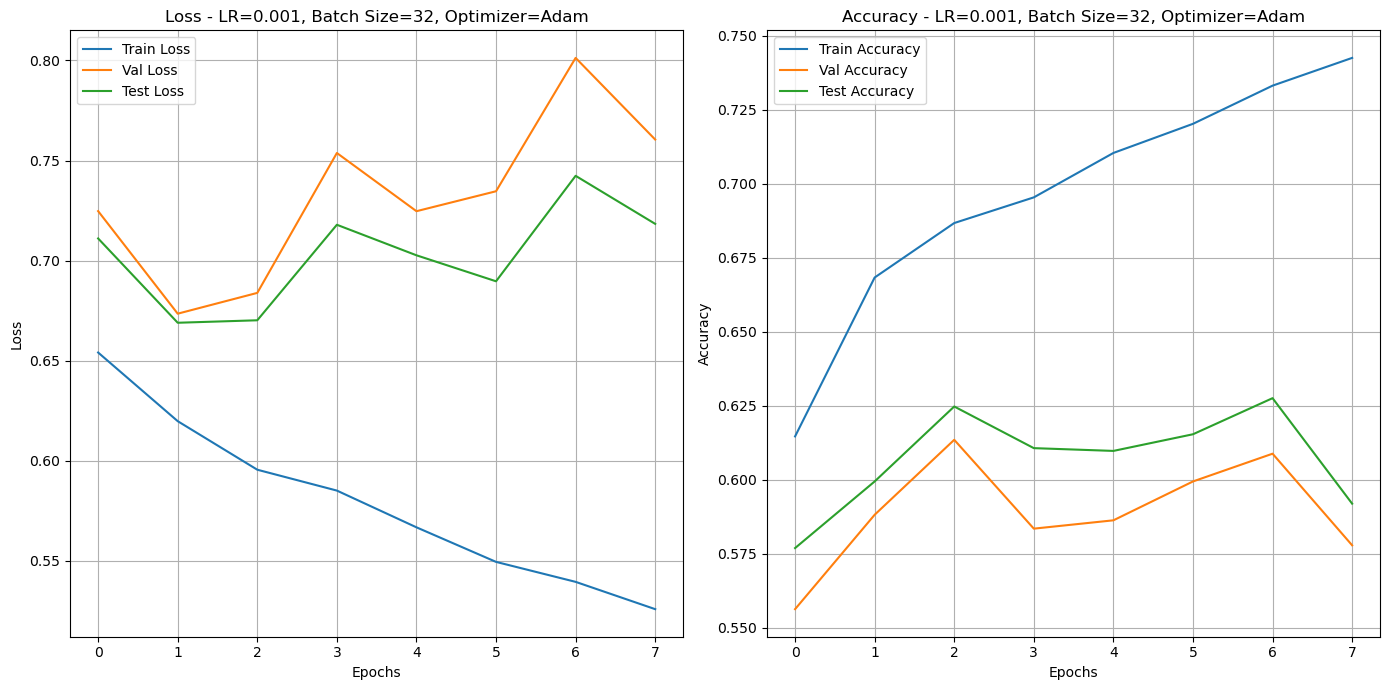


Training with parameters: Learning Rate=0.001, Batch Size=32, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.5942, Train Accuracy: 0.6952
Test Loss: 0.7398, Test Accuracy: 0.5976
Val Loss: 0.7849, Val Accuracy: 0.5675
Model saved.

Epoch 2/100
Train Loss: 0.5214, Train Accuracy: 0.7437
Test Loss: 0.7048, Test Accuracy: 0.6041
Val Loss: 0.7580, Val Accuracy: 0.5694
Model saved.

Epoch 3/100
Train Loss: 0.4982, Train Accuracy: 0.7573
Test Loss: 0.7322, Test Accuracy: 0.6144
Val Loss: 0.8056, Val Accuracy: 0.5704
Model saved.

Epoch 4/100
Train Loss: 0.4663, Train Accuracy: 0.7828
Test Loss: 0.7778, Test Accuracy: 0.6360
Val Loss: 0.8583, Val Accuracy: 0.6004
Model saved.

Epoch 5/100
Train Loss: 0.4452, Train Accuracy: 0.7912
Test Loss: 0.7719, Test Accuracy: 0.6173
Val Loss: 0.8507, Val Accuracy: 0.5816
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.4261, Train Accuracy: 0.8081
Test Loss: 0.8311, Test Accuracy: 0.6032
Val Loss: 0.8940, Val Ac

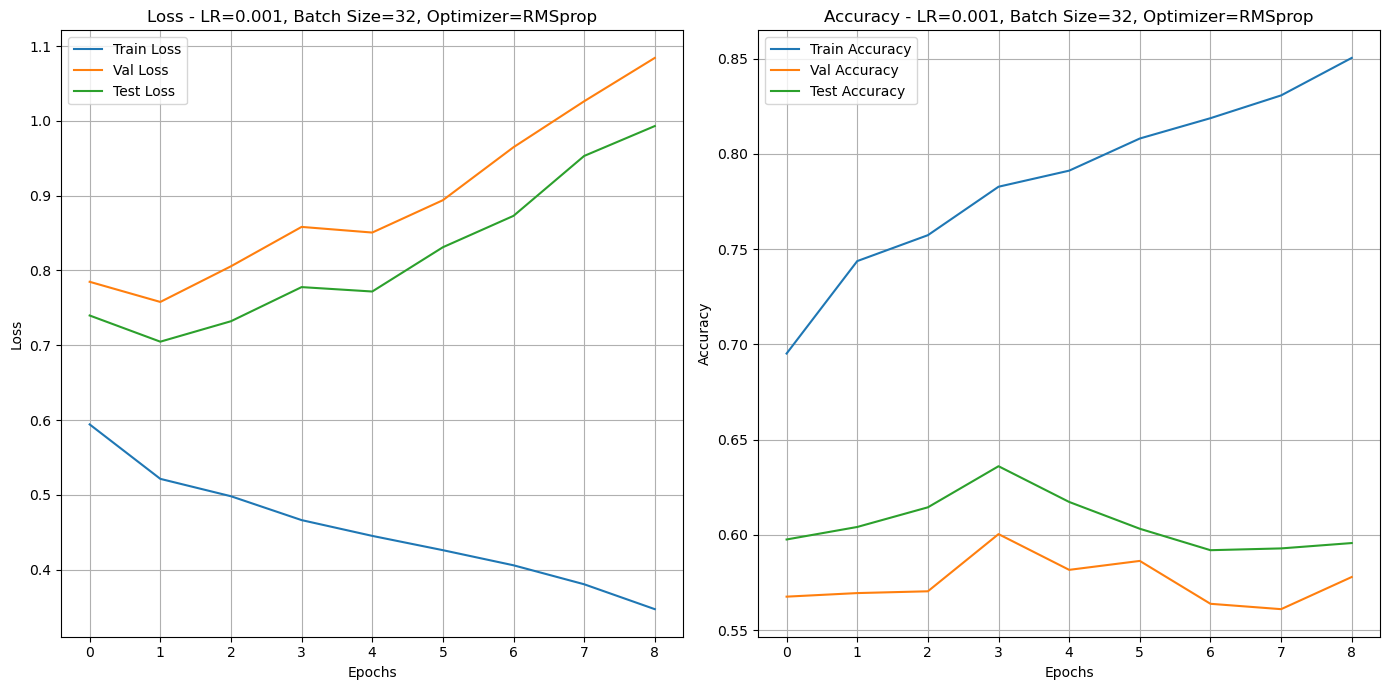


Training with parameters: Learning Rate=0.001, Batch Size=64, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.2825, Train Accuracy: 0.8859
Test Loss: 0.9877, Test Accuracy: 0.6051
Val Loss: 1.0897, Val Accuracy: 0.5675
Model saved.

Epoch 2/100
Train Loss: 0.2633, Train Accuracy: 0.8925
Test Loss: 0.9944, Test Accuracy: 0.6041
Val Loss: 1.1017, Val Accuracy: 0.5713
Model saved.

Epoch 3/100
Train Loss: 0.2553, Train Accuracy: 0.8966
Test Loss: 1.0016, Test Accuracy: 0.6079
Val Loss: 1.1136, Val Accuracy: 0.5797
Model saved.

Epoch 4/100
Train Loss: 0.2473, Train Accuracy: 0.9011
Test Loss: 1.0091, Test Accuracy: 0.6069
Val Loss: 1.1246, Val Accuracy: 0.5835
Model saved.

Epoch 5/100
Train Loss: 0.2468, Train Accuracy: 0.9012
Test Loss: 1.0177, Test Accuracy: 0.6107
Val Loss: 1.1358, Val Accuracy: 0.5816
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.2403, Train Accuracy: 0.9046
Test Loss: 1.0272, Test Accuracy: 0.6079
Val Loss: 1.1480, Val Accura

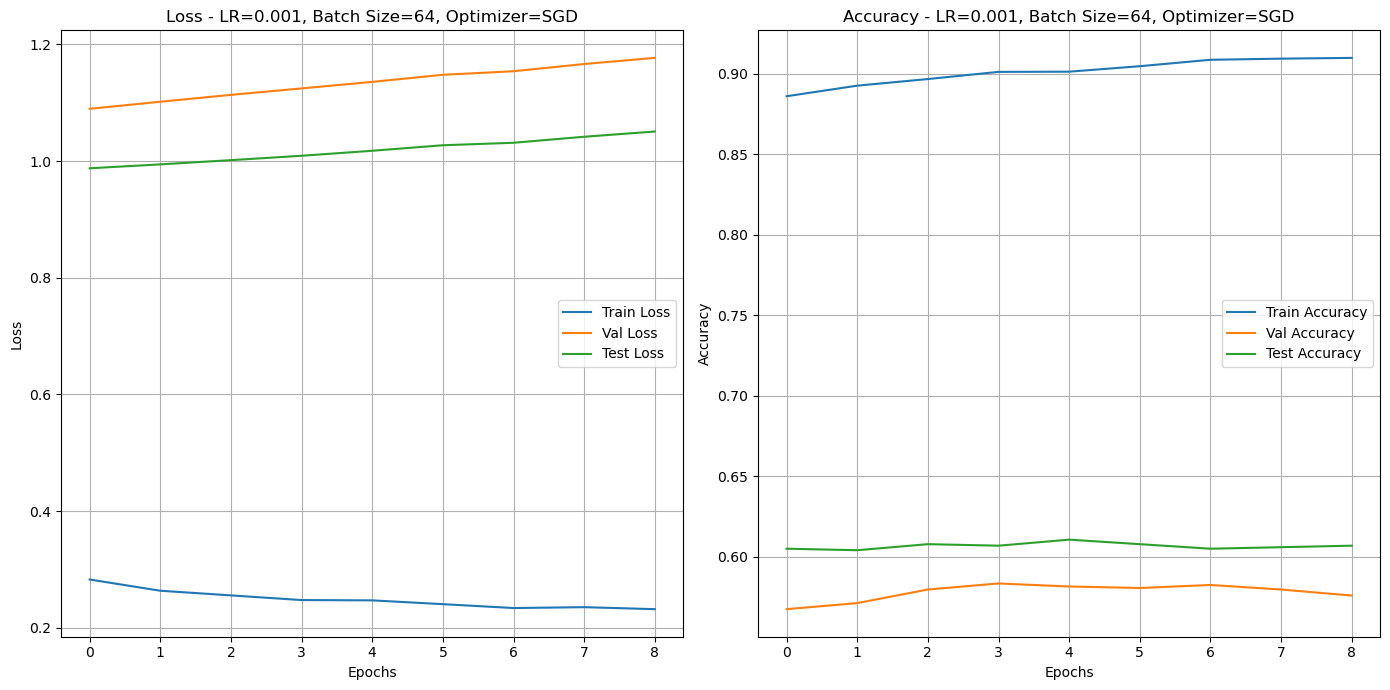


Training with parameters: Learning Rate=0.001, Batch Size=64, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.2248, Train Accuracy: 0.9125
Test Loss: 1.1371, Test Accuracy: 0.6201
Val Loss: 1.2749, Val Accuracy: 0.5704
Failed to save model to c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt: File c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt cannot be opened.

Epoch 2/100
Train Loss: 0.2010, Train Accuracy: 0.9253
Test Loss: 1.1685, Test Accuracy: 0.6135
Val Loss: 1.3039, Val Accuracy: 0.5713
Model saved.

Epoch 3/100
Train Loss: 0.1931, Train Accuracy: 0.9270
Test Loss: 1.1896, Test Accuracy: 0.6088
Val Loss: 1.3292, Val Accuracy: 0.5675
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.1837, Train Accuracy: 0.9313
Test Loss: 1.2058, Test Accuracy: 0.6041
Val Loss: 1

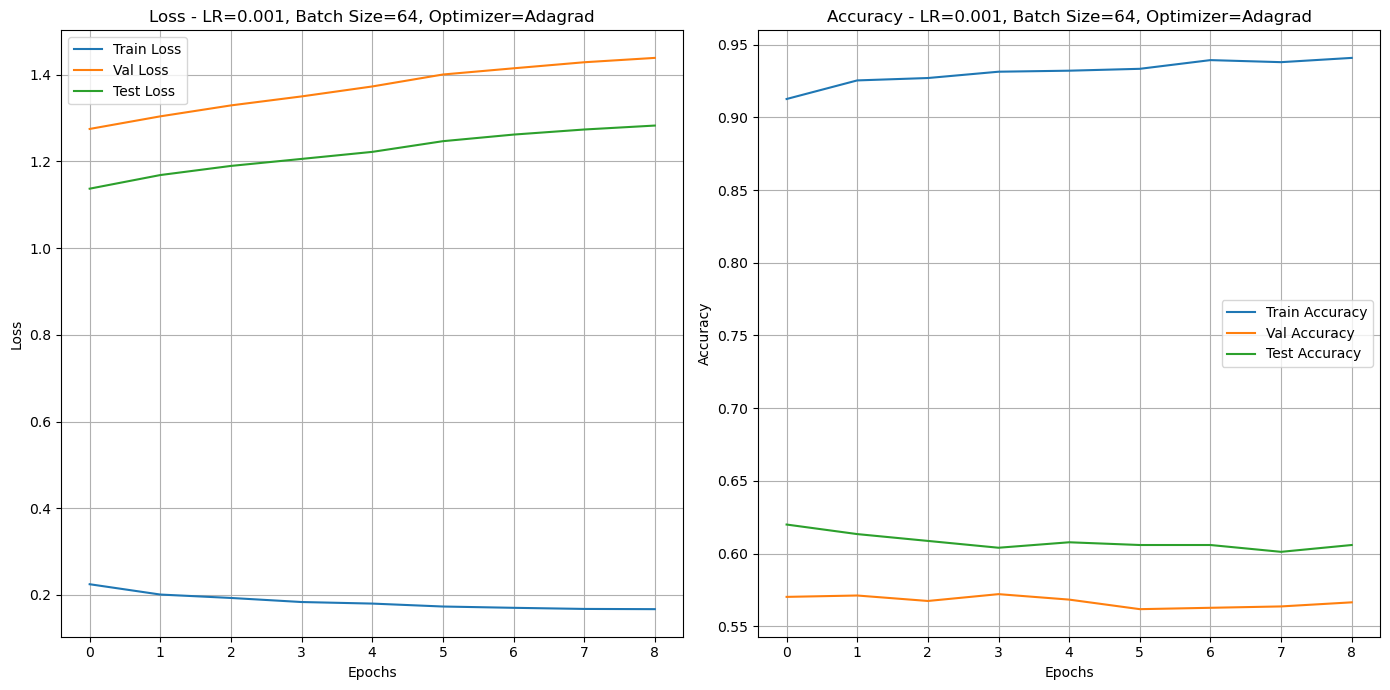


Training with parameters: Learning Rate=0.001, Batch Size=64, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.2462, Train Accuracy: 0.8996
Test Loss: 1.1805, Test Accuracy: 0.6079
Val Loss: 1.2975, Val Accuracy: 0.5638
Model saved.

Epoch 2/100
Train Loss: 0.2098, Train Accuracy: 0.9166
Test Loss: 1.3270, Test Accuracy: 0.6210
Val Loss: 1.4622, Val Accuracy: 0.5750
Model saved.

Epoch 3/100
Train Loss: 0.1930, Train Accuracy: 0.9220
Test Loss: 1.4165, Test Accuracy: 0.6023
Val Loss: 1.5206, Val Accuracy: 0.5797
Model saved.

Epoch 4/100
Train Loss: 0.1696, Train Accuracy: 0.9309
Test Loss: 1.5712, Test Accuracy: 0.6220
Val Loss: 1.7063, Val Accuracy: 0.5919
Model saved.

Epoch 5/100
Train Loss: 0.1634, Train Accuracy: 0.9373
Test Loss: 1.5769, Test Accuracy: 0.6041
Val Loss: 1.7935, Val Accuracy: 0.5722
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.1424, Train Accuracy: 0.9448
Test Loss: 1.7315, Test Accuracy: 0.6088
Val Loss: 1.9456, Val Accur

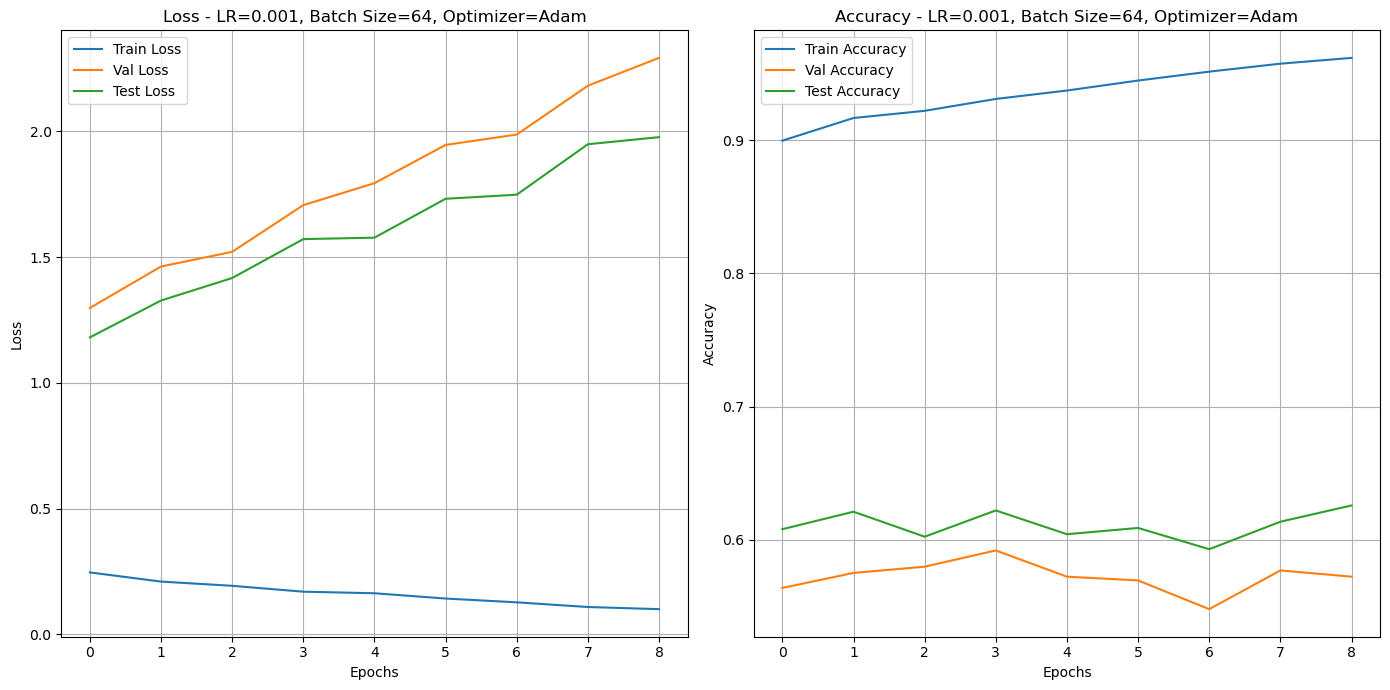


Training with parameters: Learning Rate=0.001, Batch Size=64, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.4422, Train Accuracy: 0.8205
Test Loss: 1.2821, Test Accuracy: 0.5807
Val Loss: 1.3753, Val Accuracy: 0.5713
Failed to save model to c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt: File c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt cannot be opened.

Epoch 2/100
Train Loss: 0.1797, Train Accuracy: 0.9291
Test Loss: 1.4624, Test Accuracy: 0.5750
Val Loss: 1.6049, Val Accuracy: 0.5535
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.1348, Train Accuracy: 0.9474
Test Loss: 1.6917, Test Accuracy: 0.5863
Val Loss: 1.7761, Val Accuracy: 0.5535
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.1269, Train Accuracy: 0.9528
Test Loss: 1.9351, Test Accuracy: 0.

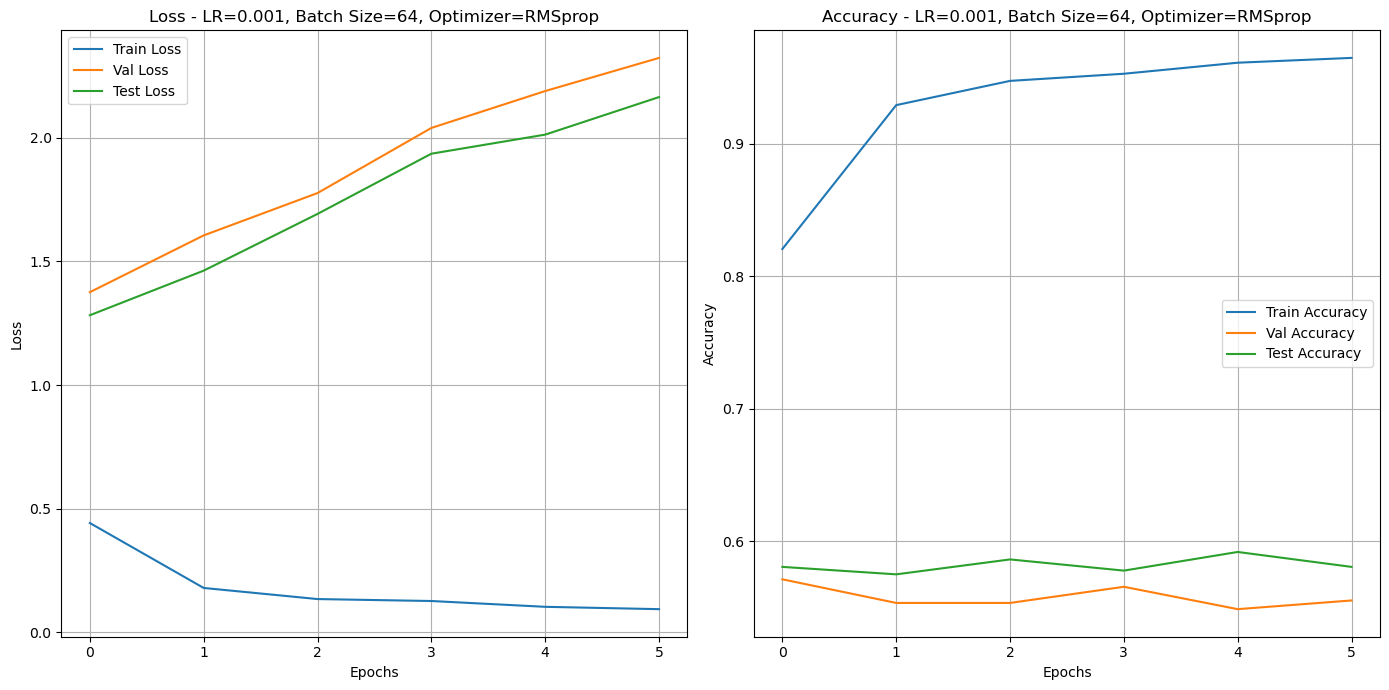


Training with parameters: Learning Rate=0.001, Batch Size=128, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0691, Train Accuracy: 0.9744
Test Loss: 2.1504, Test Accuracy: 0.5957
Val Loss: 2.3409, Val Accuracy: 0.5553
Model saved.

Epoch 2/100
Train Loss: 0.0545, Train Accuracy: 0.9816
Test Loss: 2.1545, Test Accuracy: 0.5938
Val Loss: 2.3367, Val Accuracy: 0.5591
Model saved.

Epoch 3/100
Train Loss: 0.0522, Train Accuracy: 0.9805
Test Loss: 2.1533, Test Accuracy: 0.5947
Val Loss: 2.3338, Val Accuracy: 0.5629
Model saved.

Epoch 4/100
Train Loss: 0.0486, Train Accuracy: 0.9822
Test Loss: 2.1606, Test Accuracy: 0.5966
Val Loss: 2.3398, Val Accuracy: 0.5619
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0469, Train Accuracy: 0.9844
Test Loss: 2.1628, Test Accuracy: 0.5938
Val Loss: 2.3421, Val Accuracy: 0.5629
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0449, Train Accuracy: 0.9843
Test Loss: 2.1643, Test Accuracy: 0.5929
Val Loss: 2

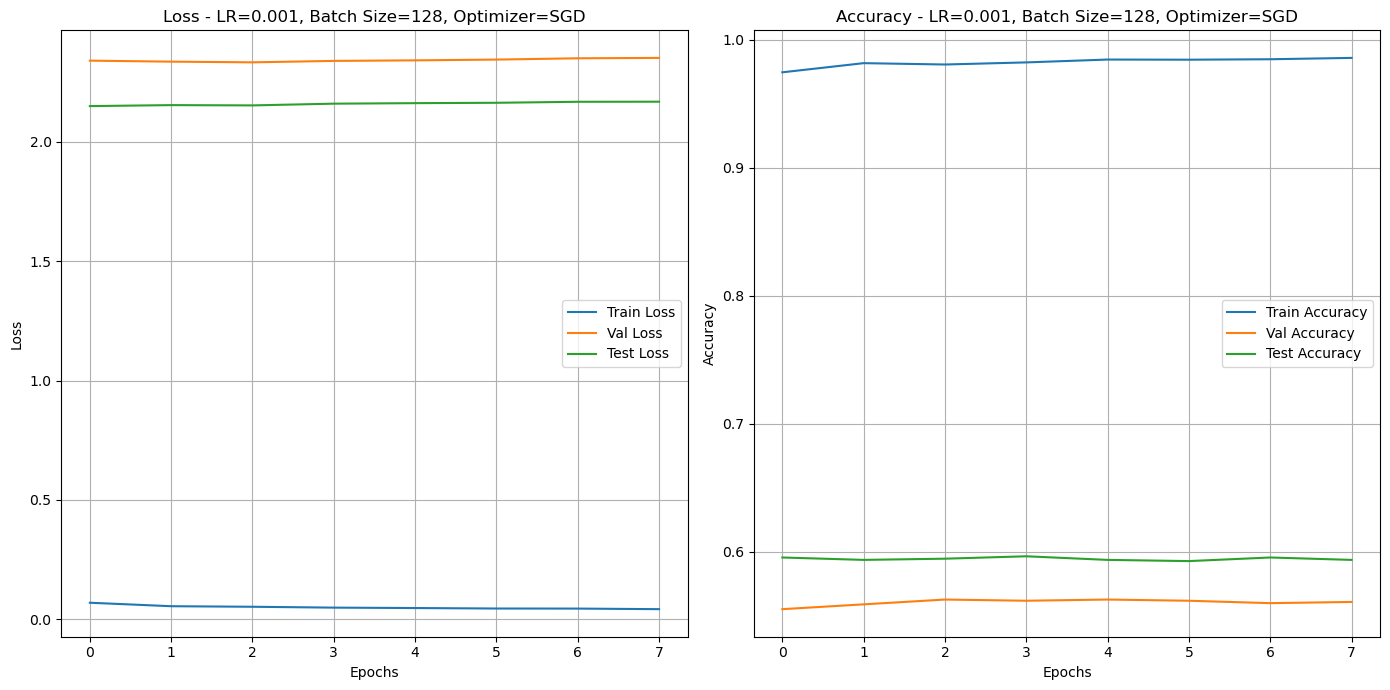


Training with parameters: Learning Rate=0.001, Batch Size=128, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0385, Train Accuracy: 0.9868
Test Loss: 2.2373, Test Accuracy: 0.5976
Val Loss: 2.4883, Val Accuracy: 0.5563
Model saved.

Epoch 2/100
Train Loss: 0.0265, Train Accuracy: 0.9919
Test Loss: 2.2927, Test Accuracy: 0.5966
Val Loss: 2.5307, Val Accuracy: 0.5572
Model saved.

Epoch 3/100
Train Loss: 0.0248, Train Accuracy: 0.9921
Test Loss: 2.3292, Test Accuracy: 0.5938
Val Loss: 2.5806, Val Accuracy: 0.5657
Model saved.

Epoch 4/100
Train Loss: 0.0233, Train Accuracy: 0.9928
Test Loss: 2.3693, Test Accuracy: 0.5957
Val Loss: 2.6191, Val Accuracy: 0.5685
Model saved.

Epoch 5/100
Train Loss: 0.0225, Train Accuracy: 0.9917
Test Loss: 2.3888, Test Accuracy: 0.5985
Val Loss: 2.6377, Val Accuracy: 0.5666
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.0204, Train Accuracy: 0.9939
Test Loss: 2.3929, Test Accuracy: 0.5947
Val Loss: 2.6526, Val A

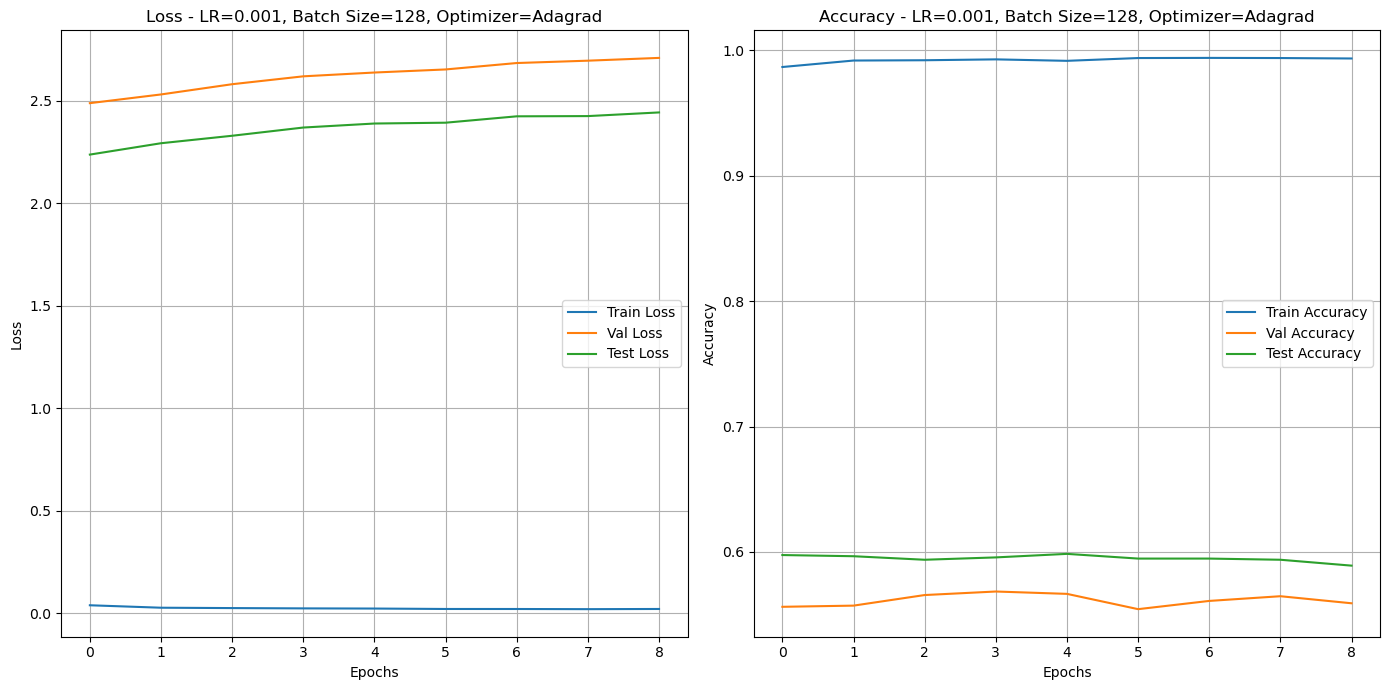


Training with parameters: Learning Rate=0.001, Batch Size=128, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0507, Train Accuracy: 0.9822
Test Loss: 2.5908, Test Accuracy: 0.5976
Val Loss: 2.8500, Val Accuracy: 0.5497
Model saved.

Epoch 2/100
Train Loss: 0.0449, Train Accuracy: 0.9826
Test Loss: 2.6261, Test Accuracy: 0.5863
Val Loss: 2.9858, Val Accuracy: 0.5675
Model saved.

Epoch 3/100
Train Loss: 0.0412, Train Accuracy: 0.9844
Test Loss: 2.6382, Test Accuracy: 0.5985
Val Loss: 3.0099, Val Accuracy: 0.5572
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0464, Train Accuracy: 0.9825
Test Loss: 2.7231, Test Accuracy: 0.6032
Val Loss: 3.2239, Val Accuracy: 0.5600
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0416, Train Accuracy: 0.9837
Test Loss: 2.8557, Test Accuracy: 0.5854
Val Loss: 3.2626, Val Accuracy: 0.5610
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0431, Train Accuracy: 0.9832
Test Loss: 2.8003, Test Accuracy: 0

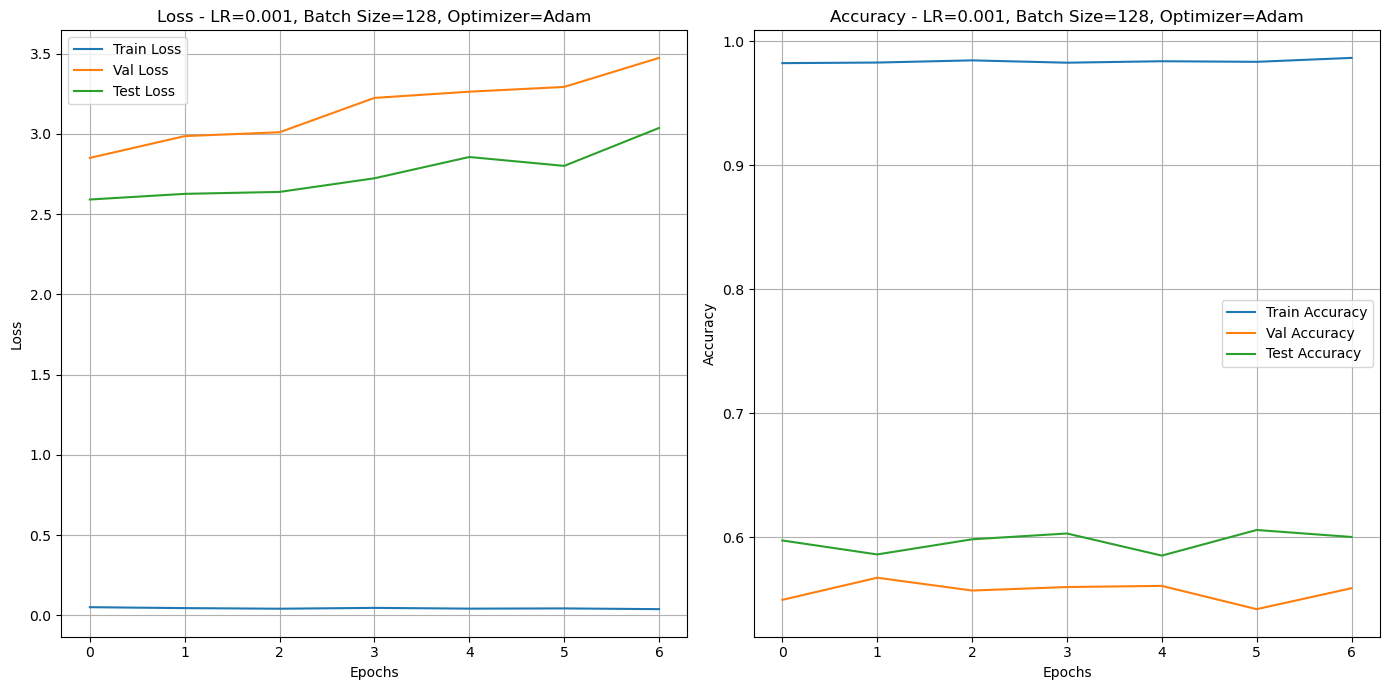


Training with parameters: Learning Rate=0.001, Batch Size=128, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.5334, Train Accuracy: 0.8469
Test Loss: 1.6581, Test Accuracy: 0.5872
Val Loss: 1.8833, Val Accuracy: 0.5488
Model saved.

Epoch 2/100
Train Loss: 0.1163, Train Accuracy: 0.9563
Test Loss: 1.8394, Test Accuracy: 0.6107
Val Loss: 2.1772, Val Accuracy: 0.5516
Model saved.

Epoch 3/100
Train Loss: 0.0689, Train Accuracy: 0.9743
Test Loss: 2.1757, Test Accuracy: 0.6051
Val Loss: 2.4782, Val Accuracy: 0.5469
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0566, Train Accuracy: 0.9808
Test Loss: 2.2333, Test Accuracy: 0.5919
Val Loss: 2.5494, Val Accuracy: 0.5525
Model saved.

Epoch 5/100
Train Loss: 0.0517, Train Accuracy: 0.9800
Test Loss: 2.3797, Test Accuracy: 0.6069
Val Loss: 2.7150, Val Accuracy: 0.5328
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.0453, Train Accuracy: 0.9838
Test Loss: 2.5340, Test Accuracy: 0.6276
Val Los

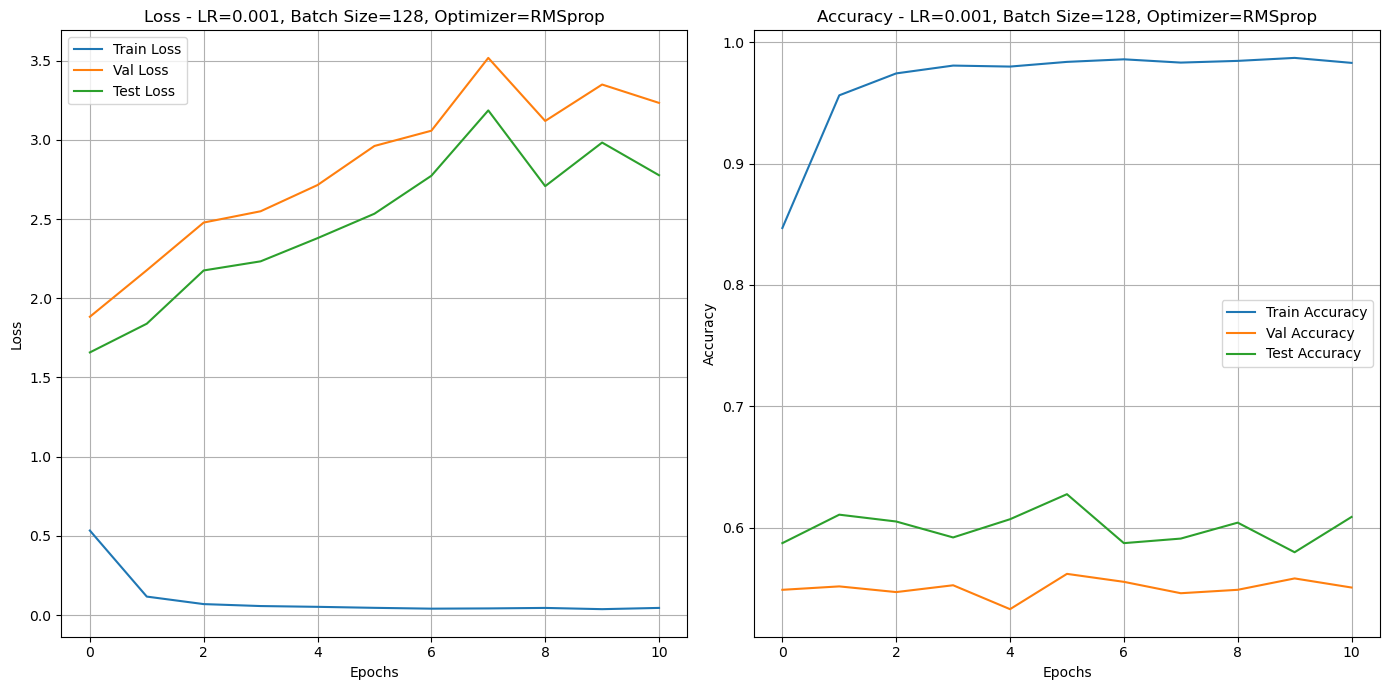


Training with parameters: Learning Rate=0.0005, Batch Size=32, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0166, Train Accuracy: 0.9932
Test Loss: 2.7267, Test Accuracy: 0.6098
Val Loss: 3.1667, Val Accuracy: 0.5507
Model saved.

Epoch 2/100
Train Loss: 0.0186, Train Accuracy: 0.9930
Test Loss: 2.7287, Test Accuracy: 0.6079
Val Loss: 3.1705, Val Accuracy: 0.5497
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0181, Train Accuracy: 0.9924
Test Loss: 2.7325, Test Accuracy: 0.6098
Val Loss: 3.1731, Val Accuracy: 0.5488
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0170, Train Accuracy: 0.9933
Test Loss: 2.7332, Test Accuracy: 0.6098
Val Loss: 3.1770, Val Accuracy: 0.5497
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0158, Train Accuracy: 0.9933
Test Loss: 2.7371, Test Accuracy: 0.6098
Val Loss: 3.1792, Val Accuracy: 0.5525
Model saved.

Epoch 6/100
Train Loss: 0.0155, Train Accuracy: 0.9943
Test Loss: 2.7375, Test Accuracy: 0.

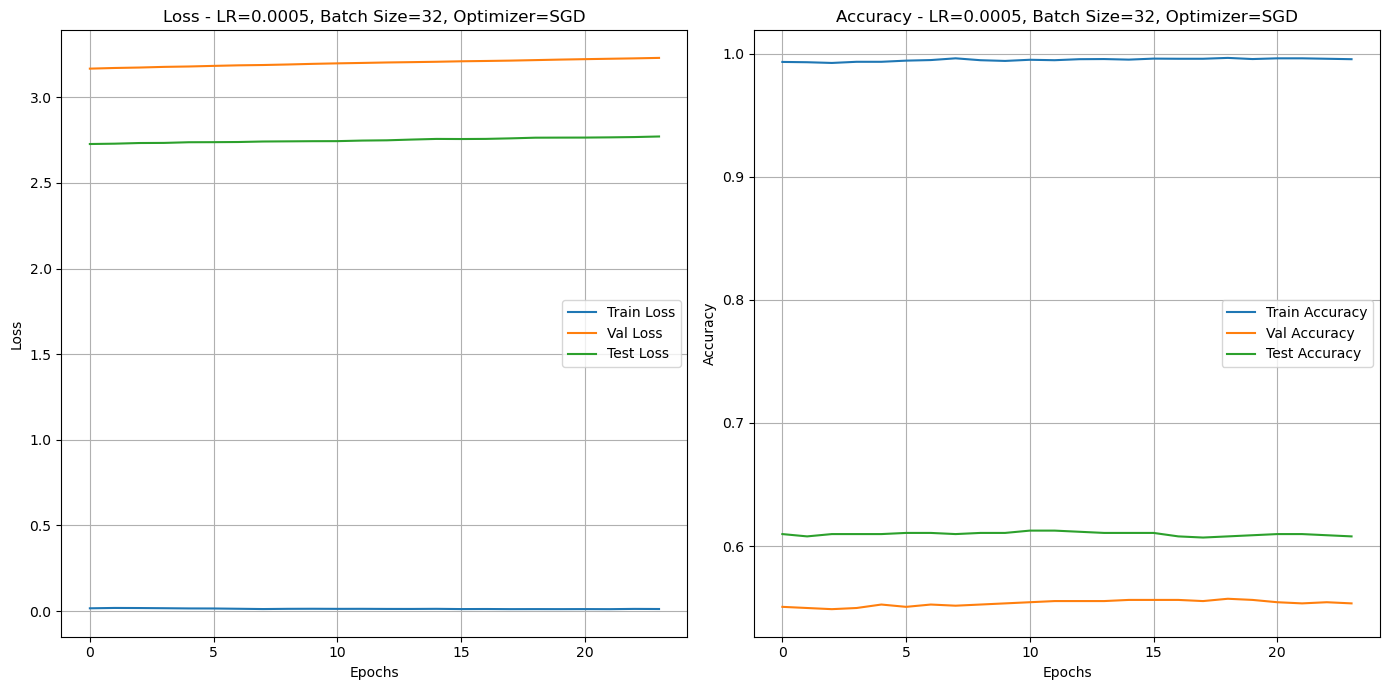


Training with parameters: Learning Rate=0.0005, Batch Size=32, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0140, Train Accuracy: 0.9948
Test Loss: 2.8247, Test Accuracy: 0.6144
Val Loss: 3.2703, Val Accuracy: 0.5572
Model saved.

Epoch 2/100
Train Loss: 0.0100, Train Accuracy: 0.9961
Test Loss: 2.8403, Test Accuracy: 0.6116
Val Loss: 3.3050, Val Accuracy: 0.5572
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0093, Train Accuracy: 0.9967
Test Loss: 2.8556, Test Accuracy: 0.6126
Val Loss: 3.3173, Val Accuracy: 0.5582
Model saved.

Epoch 4/100
Train Loss: 0.0098, Train Accuracy: 0.9964
Test Loss: 2.8623, Test Accuracy: 0.6135
Val Loss: 3.3353, Val Accuracy: 0.5563
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0097, Train Accuracy: 0.9962
Test Loss: 2.8805, Test Accuracy: 0.6144
Val Loss: 3.3463, Val Accuracy: 0.5572
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0087, Train Accuracy: 0.9970
Test Loss: 2.8837, Test Accuracy

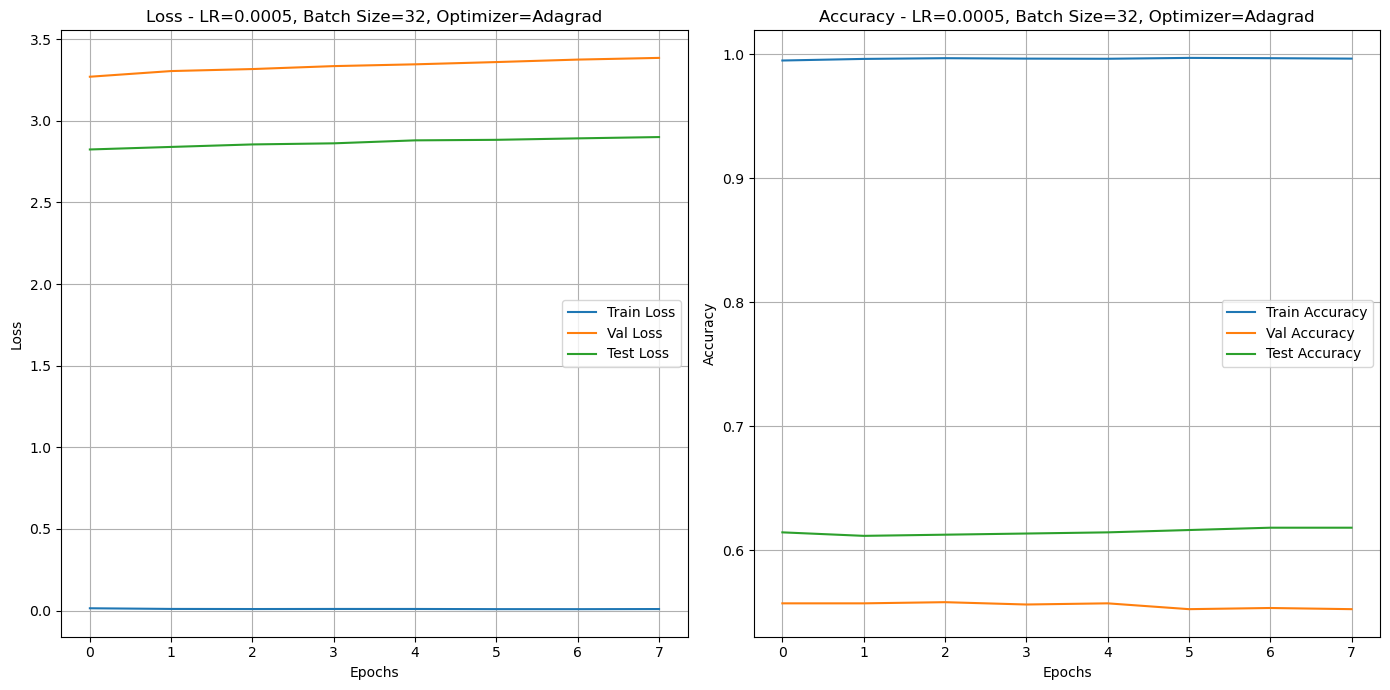


Training with parameters: Learning Rate=0.0005, Batch Size=32, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0279, Train Accuracy: 0.9891
Test Loss: 3.0854, Test Accuracy: 0.5976
Val Loss: 3.5543, Val Accuracy: 0.5694
Model saved.

Epoch 2/100
Train Loss: 0.0222, Train Accuracy: 0.9913
Test Loss: 3.1591, Test Accuracy: 0.6116
Val Loss: 3.6322, Val Accuracy: 0.5516
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0284, Train Accuracy: 0.9892
Test Loss: 3.2629, Test Accuracy: 0.5994
Val Loss: 3.7676, Val Accuracy: 0.5797
Model saved.

Epoch 4/100
Train Loss: 0.0257, Train Accuracy: 0.9907
Test Loss: 3.4258, Test Accuracy: 0.5938
Val Loss: 3.9832, Val Accuracy: 0.5450
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0272, Train Accuracy: 0.9906
Test Loss: 3.4489, Test Accuracy: 0.6060
Val Loss: 3.9842, Val Accuracy: 0.5516
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0282, Train Accuracy: 0.9899
Test Loss: 3.4906, Test Accuracy: 0

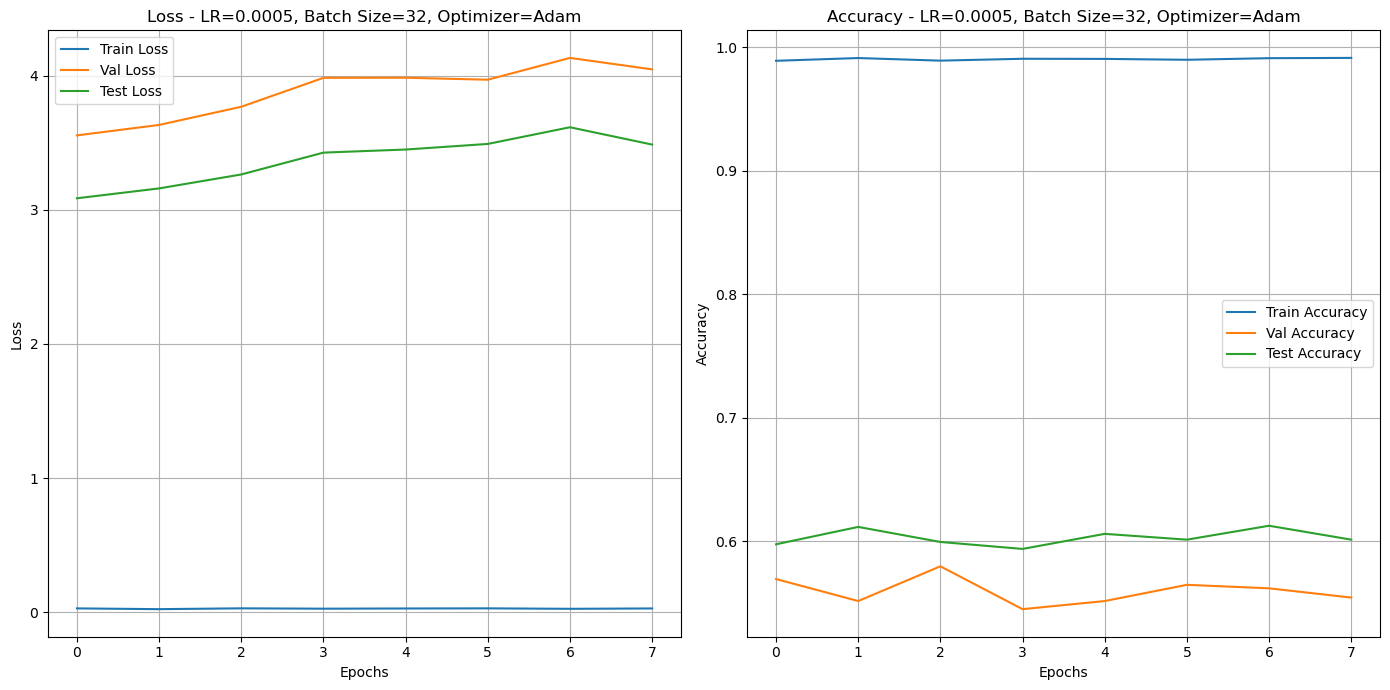


Training with parameters: Learning Rate=0.0005, Batch Size=32, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0999, Train Accuracy: 0.9737
Test Loss: 3.3489, Test Accuracy: 0.5985
Val Loss: 3.7706, Val Accuracy: 0.5525
Model saved.

Epoch 2/100
Train Loss: 0.0353, Train Accuracy: 0.9878
Test Loss: 3.5743, Test Accuracy: 0.6163
Val Loss: 3.9793, Val Accuracy: 0.5722
Model saved.

Epoch 3/100
Train Loss: 0.0271, Train Accuracy: 0.9913
Test Loss: 3.5594, Test Accuracy: 0.6023
Val Loss: 4.0389, Val Accuracy: 0.5591
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0281, Train Accuracy: 0.9902
Test Loss: 3.5949, Test Accuracy: 0.6051
Val Loss: 4.1045, Val Accuracy: 0.5563
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0340, Train Accuracy: 0.9893
Test Loss: 3.5233, Test Accuracy: 0.6069
Val Loss: 4.1197, Val Accuracy: 0.5544
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0365, Train Accuracy: 0.9885
Test Loss: 3.7032, Test Accuracy

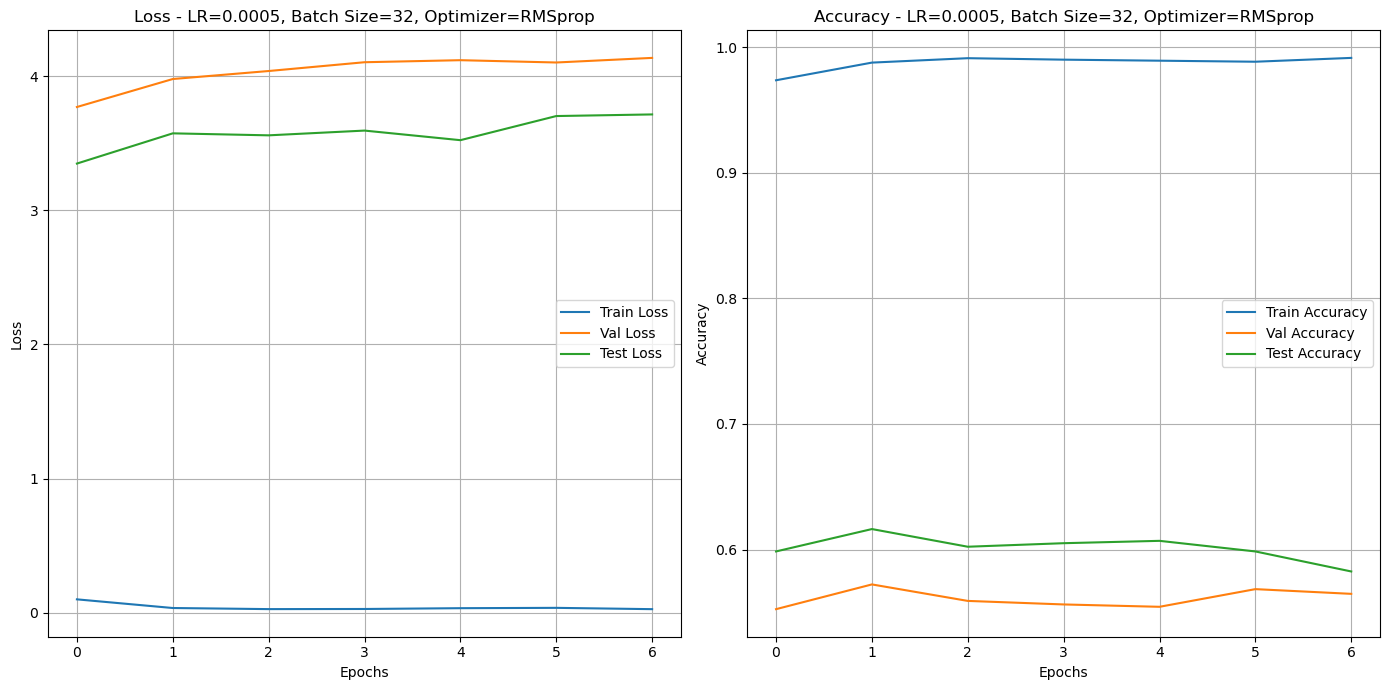


Training with parameters: Learning Rate=0.0005, Batch Size=64, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0132, Train Accuracy: 0.9951
Test Loss: 3.7536, Test Accuracy: 0.5835
Val Loss: 4.1623, Val Accuracy: 0.5647
Model saved.

Epoch 2/100
Train Loss: 0.0128, Train Accuracy: 0.9952
Test Loss: 3.7529, Test Accuracy: 0.5807
Val Loss: 4.1638, Val Accuracy: 0.5629
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0104, Train Accuracy: 0.9957
Test Loss: 3.7551, Test Accuracy: 0.5779
Val Loss: 4.1675, Val Accuracy: 0.5657
Model saved.

Epoch 4/100
Train Loss: 0.0118, Train Accuracy: 0.9959
Test Loss: 3.7529, Test Accuracy: 0.5797
Val Loss: 4.1667, Val Accuracy: 0.5657
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0123, Train Accuracy: 0.9954
Test Loss: 3.7540, Test Accuracy: 0.5816
Val Loss: 4.1676, Val Accuracy: 0.5666
Model saved.

Epoch 6/100
Train Loss: 0.0101, Train Accuracy: 0.9961
Test Loss: 3.7538, Test Accuracy: 0.5807
Val Loss: 4

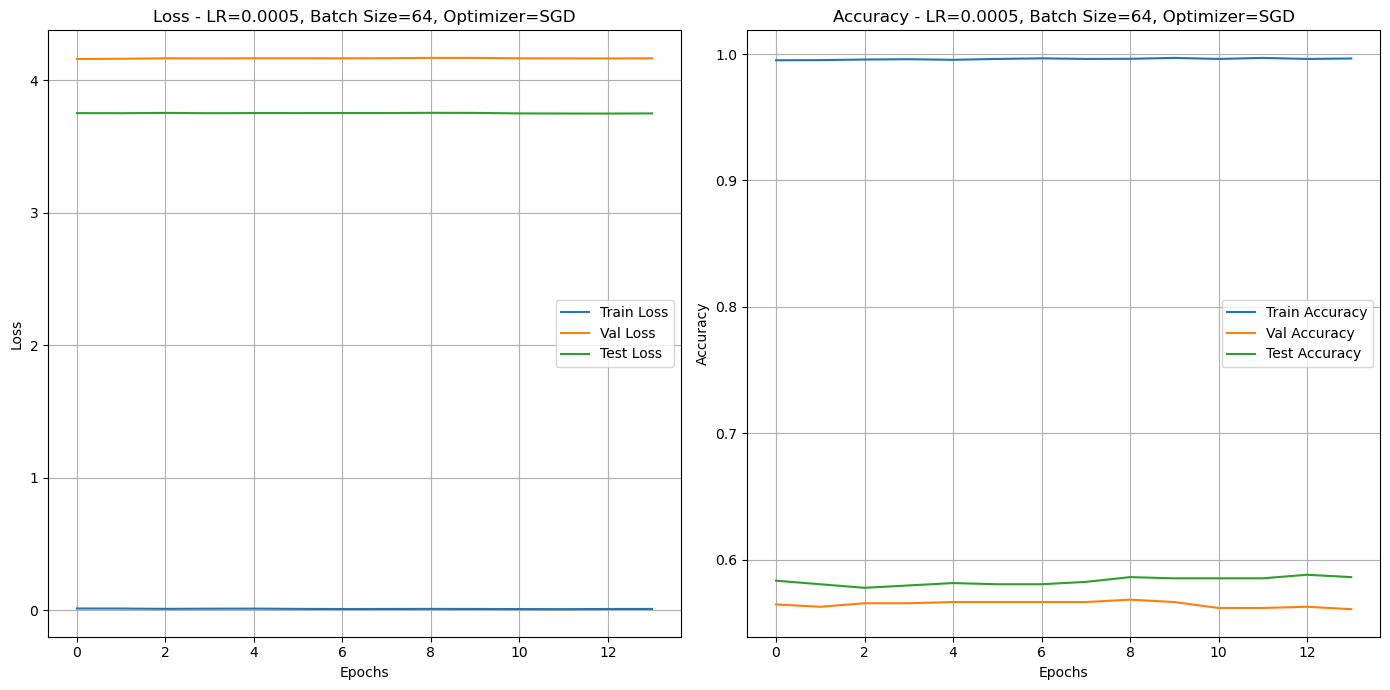


Training with parameters: Learning Rate=0.0005, Batch Size=64, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0085, Train Accuracy: 0.9967
Test Loss: 3.7476, Test Accuracy: 0.5976
Val Loss: 4.1905, Val Accuracy: 0.5675
Failed to save model to c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt: File c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt cannot be opened.

Epoch 2/100
Train Loss: 0.0060, Train Accuracy: 0.9973
Test Loss: 3.7581, Test Accuracy: 0.5966
Val Loss: 4.2211, Val Accuracy: 0.5610
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0054, Train Accuracy: 0.9982
Test Loss: 3.7625, Test Accuracy: 0.5947
Val Loss: 4.2361, Val Accuracy: 0.5629
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0055, Train Accuracy: 0.9974
Test Loss: 3.7651, Test Accuracy: 0

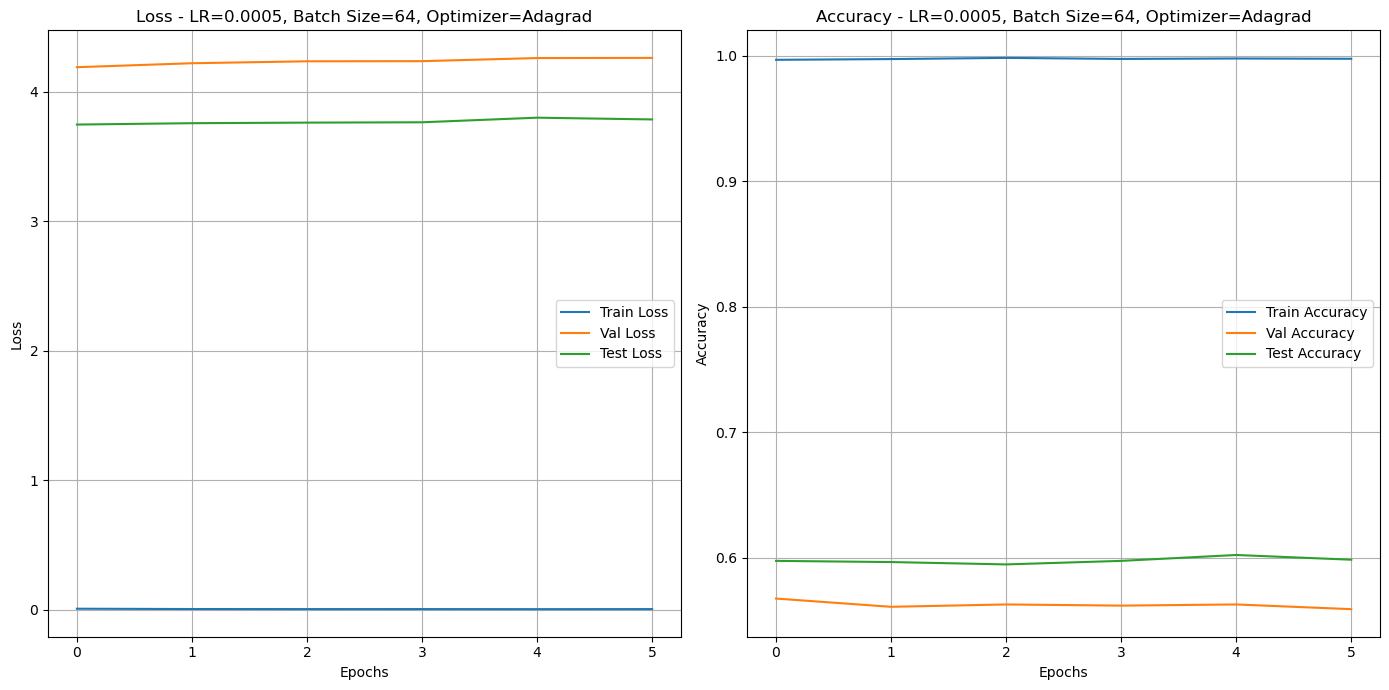


Training with parameters: Learning Rate=0.0005, Batch Size=64, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0133, Train Accuracy: 0.9958
Test Loss: 3.8476, Test Accuracy: 0.5835
Val Loss: 4.2925, Val Accuracy: 0.5647
Model saved.

Epoch 2/100
Train Loss: 0.0144, Train Accuracy: 0.9951
Test Loss: 3.8835, Test Accuracy: 0.6116
Val Loss: 4.3522, Val Accuracy: 0.5619
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0214, Train Accuracy: 0.9926
Test Loss: 3.8824, Test Accuracy: 0.6069
Val Loss: 4.2402, Val Accuracy: 0.5779
Model saved.

Epoch 4/100
Train Loss: 0.0177, Train Accuracy: 0.9925
Test Loss: 3.9620, Test Accuracy: 0.5929
Val Loss: 4.2865, Val Accuracy: 0.5535
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0121, Train Accuracy: 0.9947
Test Loss: 3.8765, Test Accuracy: 0.5919
Val Loss: 4.3317, Val Accuracy: 0.5657
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0152, Train Accuracy: 0.9944
Test Loss: 3.9960, Test Accuracy: 0

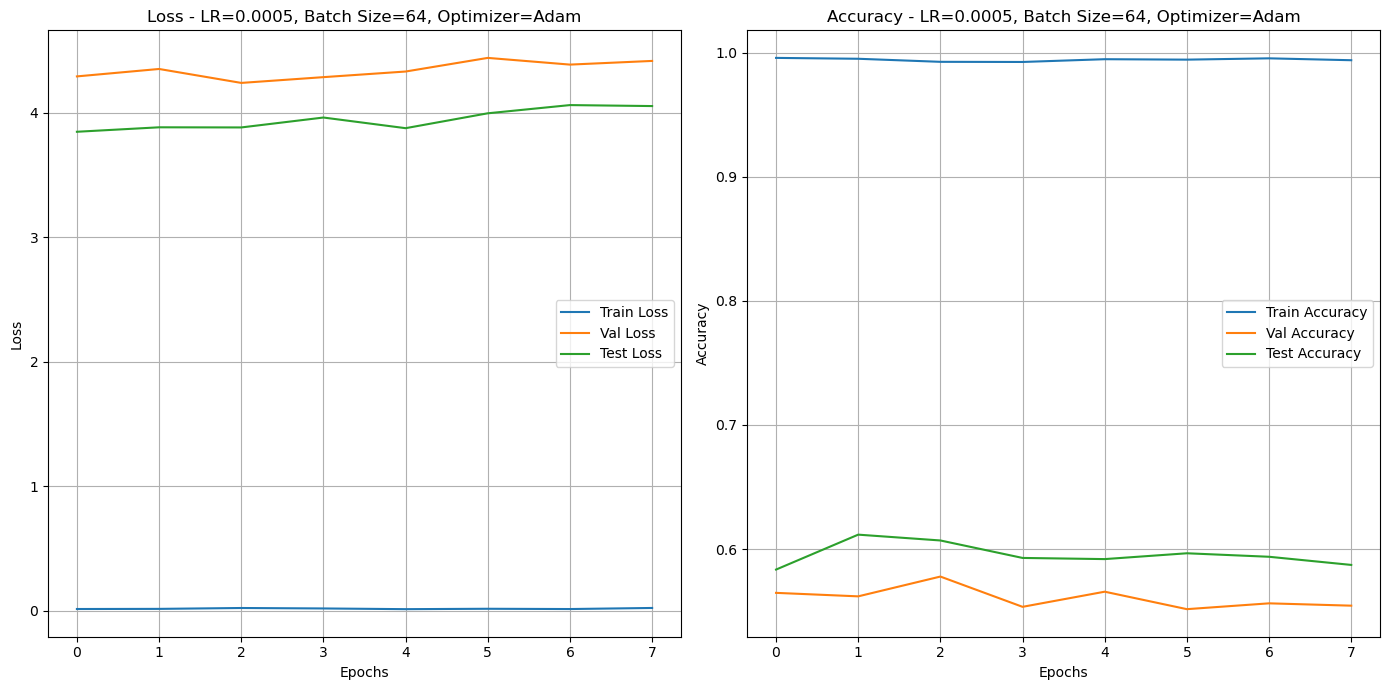


Training with parameters: Learning Rate=0.0005, Batch Size=64, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.1333, Train Accuracy: 0.9743
Test Loss: 3.5651, Test Accuracy: 0.6032
Val Loss: 3.8347, Val Accuracy: 0.5666
Model saved.

Epoch 2/100
Train Loss: 0.0185, Train Accuracy: 0.9937
Test Loss: 3.6718, Test Accuracy: 0.5938
Val Loss: 4.0597, Val Accuracy: 0.5497
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0199, Train Accuracy: 0.9928
Test Loss: 3.7678, Test Accuracy: 0.6069
Val Loss: 4.1325, Val Accuracy: 0.5666
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0141, Train Accuracy: 0.9944
Test Loss: 3.7307, Test Accuracy: 0.5976
Val Loss: 4.1743, Val Accuracy: 0.5582
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0236, Train Accuracy: 0.9923
Test Loss: 3.8116, Test Accuracy: 0.6116
Val Loss: 4.3219, Val Accuracy: 0.5619
No improvement for 4 epochs.

Epoch 6/100
Train Loss: 0.0188, Train Accuracy: 0.9934
Test Loss: 3.887

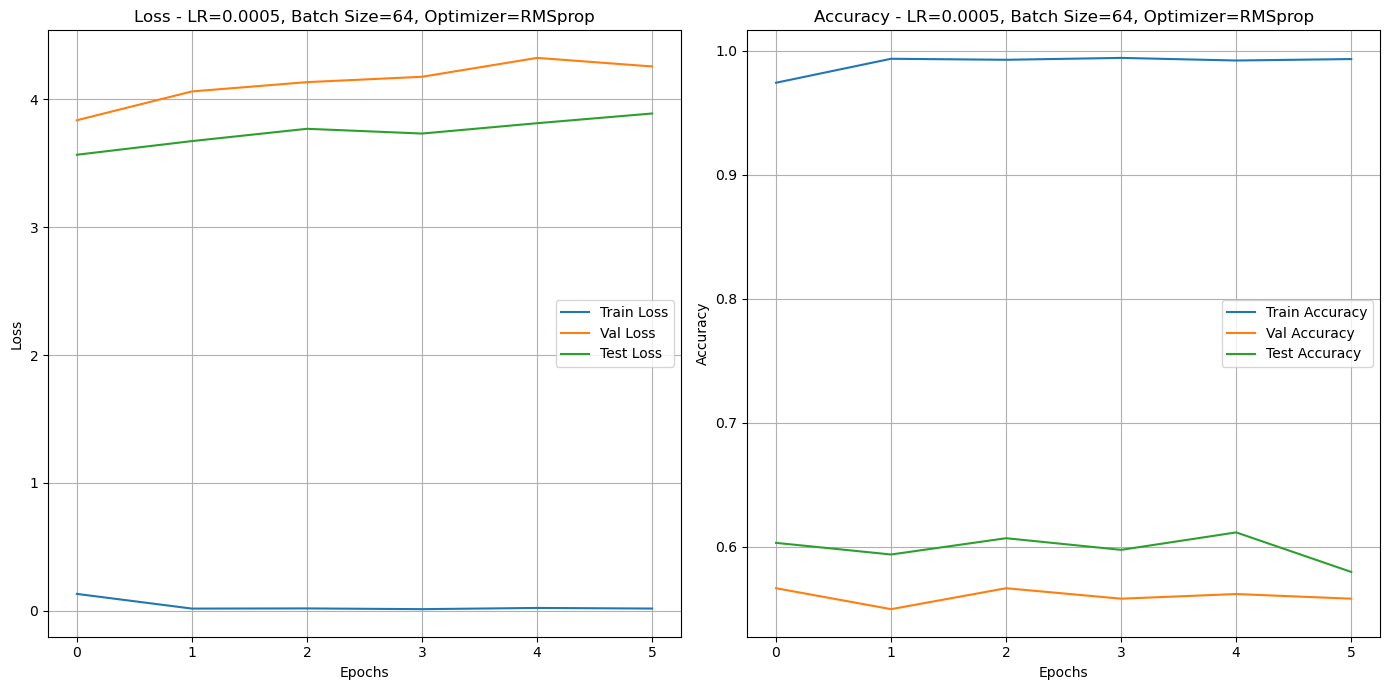


Training with parameters: Learning Rate=0.0005, Batch Size=128, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0105, Train Accuracy: 0.9954
Test Loss: 3.9133, Test Accuracy: 0.5835
Val Loss: 4.3942, Val Accuracy: 0.5563
Model saved.

Epoch 2/100
Train Loss: 0.0083, Train Accuracy: 0.9968
Test Loss: 3.8933, Test Accuracy: 0.5872
Val Loss: 4.3821, Val Accuracy: 0.5572
Model saved.

Epoch 3/100
Train Loss: 0.0083, Train Accuracy: 0.9966
Test Loss: 3.8855, Test Accuracy: 0.5891
Val Loss: 4.3780, Val Accuracy: 0.5582
Model saved.

Epoch 4/100
Train Loss: 0.0089, Train Accuracy: 0.9965
Test Loss: 3.8807, Test Accuracy: 0.5891
Val Loss: 4.3758, Val Accuracy: 0.5553
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0084, Train Accuracy: 0.9965
Test Loss: 3.8790, Test Accuracy: 0.5910
Val Loss: 4.3762, Val Accuracy: 0.5553
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0073, Train Accuracy: 0.9964
Test Loss: 3.8783, Test Accuracy: 0.5929
Val Loss: 

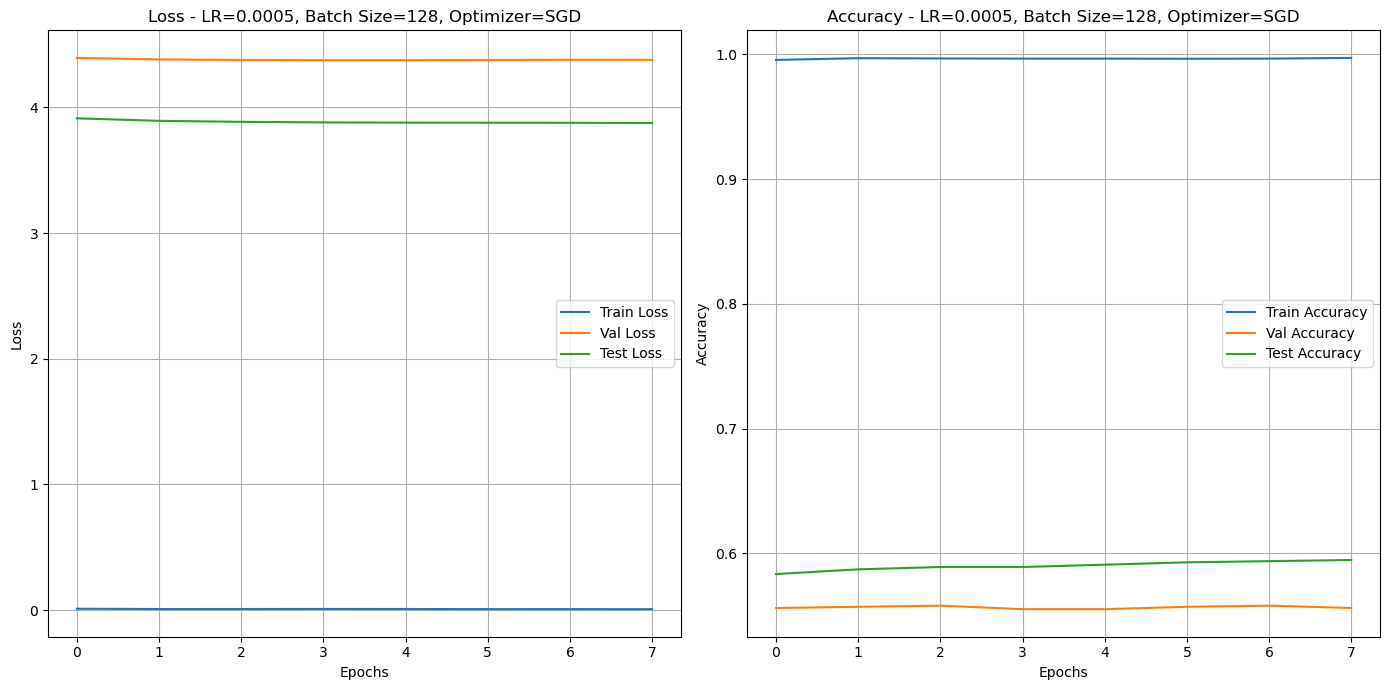


Training with parameters: Learning Rate=0.0005, Batch Size=128, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0064, Train Accuracy: 0.9972
Test Loss: 3.9033, Test Accuracy: 0.6032
Val Loss: 4.4145, Val Accuracy: 0.5582
Model saved.

Epoch 2/100
Train Loss: 0.0059, Train Accuracy: 0.9975
Test Loss: 3.9017, Test Accuracy: 0.6069
Val Loss: 4.4330, Val Accuracy: 0.5572
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0058, Train Accuracy: 0.9975
Test Loss: 3.9166, Test Accuracy: 0.6032
Val Loss: 4.4572, Val Accuracy: 0.5563
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0060, Train Accuracy: 0.9970
Test Loss: 3.9031, Test Accuracy: 0.6004
Val Loss: 4.4501, Val Accuracy: 0.5525
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0052, Train Accuracy: 0.9975
Test Loss: 3.9117, Test Accuracy: 0.6004
Val Loss: 4.4502, Val Accuracy: 0.5535
No improvement for 4 epochs.

Epoch 6/100
Train Loss: 0.0055, Train Accuracy: 0.9977
Test Loss: 3.91

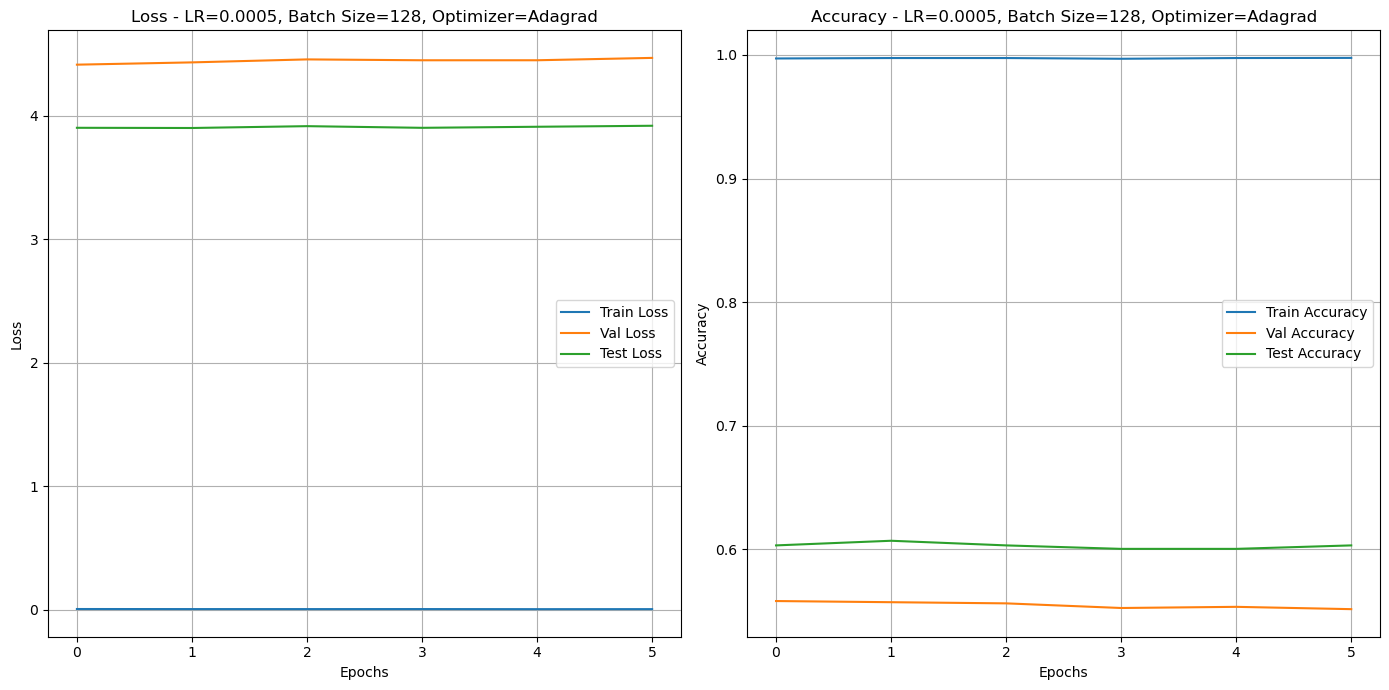


Training with parameters: Learning Rate=0.0005, Batch Size=128, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0090, Train Accuracy: 0.9962
Test Loss: 4.0411, Test Accuracy: 0.5957
Val Loss: 4.5278, Val Accuracy: 0.5544
Model saved.

Epoch 2/100
Train Loss: 0.0100, Train Accuracy: 0.9957
Test Loss: 4.0853, Test Accuracy: 0.5947
Val Loss: 4.6389, Val Accuracy: 0.5629
Model saved.

Epoch 3/100
Train Loss: 0.0124, Train Accuracy: 0.9952
Test Loss: 4.1739, Test Accuracy: 0.5901
Val Loss: 4.5798, Val Accuracy: 0.5469
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0120, Train Accuracy: 0.9945
Test Loss: 4.0741, Test Accuracy: 0.5976
Val Loss: 4.4157, Val Accuracy: 0.5544
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0094, Train Accuracy: 0.9965
Test Loss: 4.0422, Test Accuracy: 0.5844
Val Loss: 4.4895, Val Accuracy: 0.5563
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0115, Train Accuracy: 0.9955
Test Loss: 3.9978, Test Accuracy: 

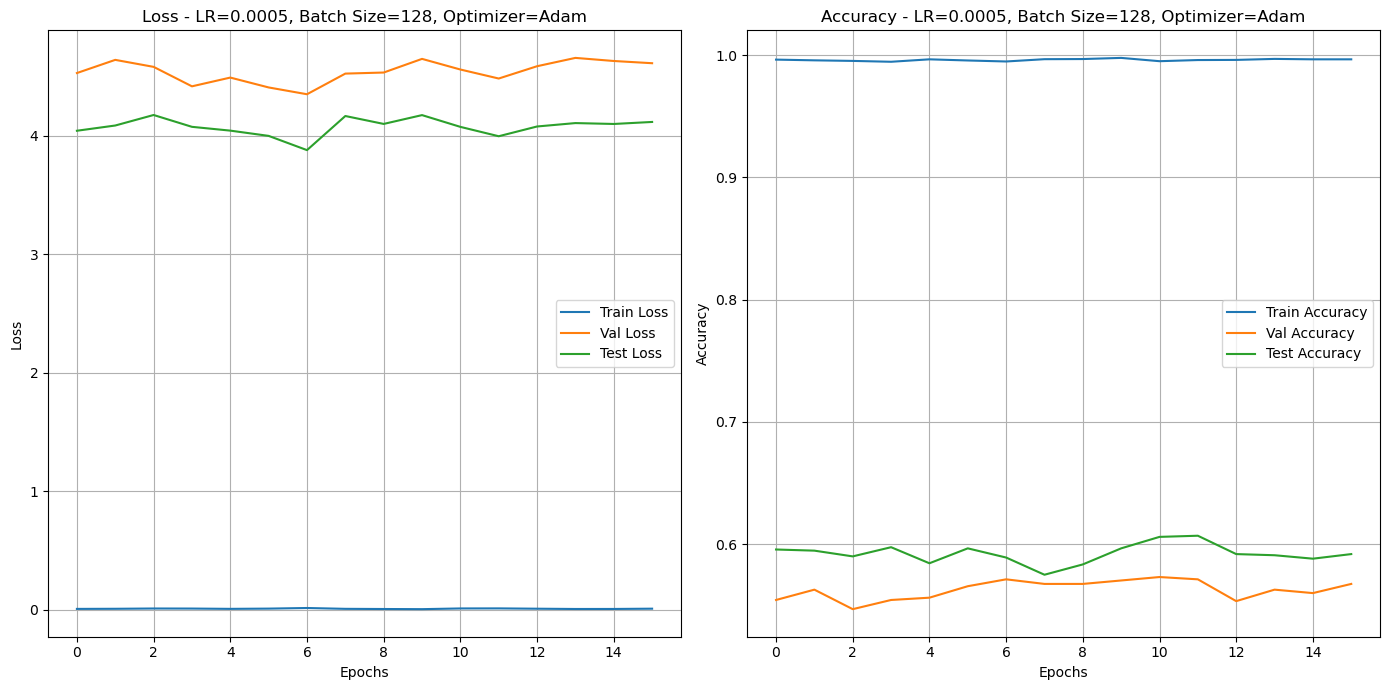


Training with parameters: Learning Rate=0.0005, Batch Size=128, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.1474, Train Accuracy: 0.9707
Test Loss: 3.6082, Test Accuracy: 0.5947
Val Loss: 4.1173, Val Accuracy: 0.5507
Failed to save model to c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt: File c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt cannot be opened.

Epoch 2/100
Train Loss: 0.0180, Train Accuracy: 0.9939
Test Loss: 3.7180, Test Accuracy: 0.5863
Val Loss: 4.2111, Val Accuracy: 0.5497
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0106, Train Accuracy: 0.9959
Test Loss: 3.8113, Test Accuracy: 0.5976
Val Loss: 4.2996, Val Accuracy: 0.5422
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0107, Train Accuracy: 0.9960
Test Loss: 3.7896, Test Accuracy: 

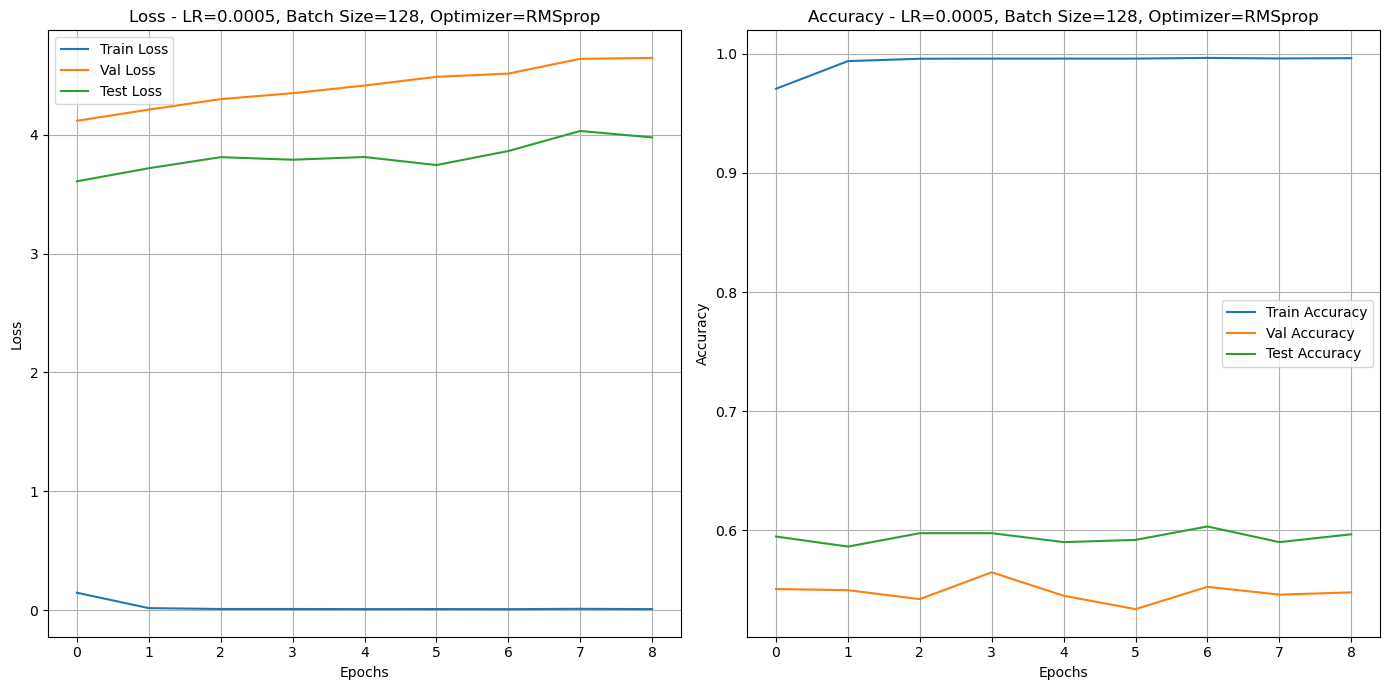


Training with parameters: Learning Rate=0.0001, Batch Size=32, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0071, Train Accuracy: 0.9971
Test Loss: 3.8591, Test Accuracy: 0.5966
Val Loss: 4.5011, Val Accuracy: 0.5478
Model saved.

Epoch 2/100
Train Loss: 0.0072, Train Accuracy: 0.9974
Test Loss: 3.8570, Test Accuracy: 0.5976
Val Loss: 4.5001, Val Accuracy: 0.5497
Model saved.

Epoch 3/100
Train Loss: 0.0065, Train Accuracy: 0.9973
Test Loss: 3.8560, Test Accuracy: 0.5985
Val Loss: 4.4995, Val Accuracy: 0.5497
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0063, Train Accuracy: 0.9975
Test Loss: 3.8541, Test Accuracy: 0.5976
Val Loss: 4.4985, Val Accuracy: 0.5488
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0064, Train Accuracy: 0.9973
Test Loss: 3.8533, Test Accuracy: 0.5976
Val Loss: 4.4981, Val Accuracy: 0.5488
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0052, Train Accuracy: 0.9977
Test Loss: 3.8516, Test Accuracy: 0.

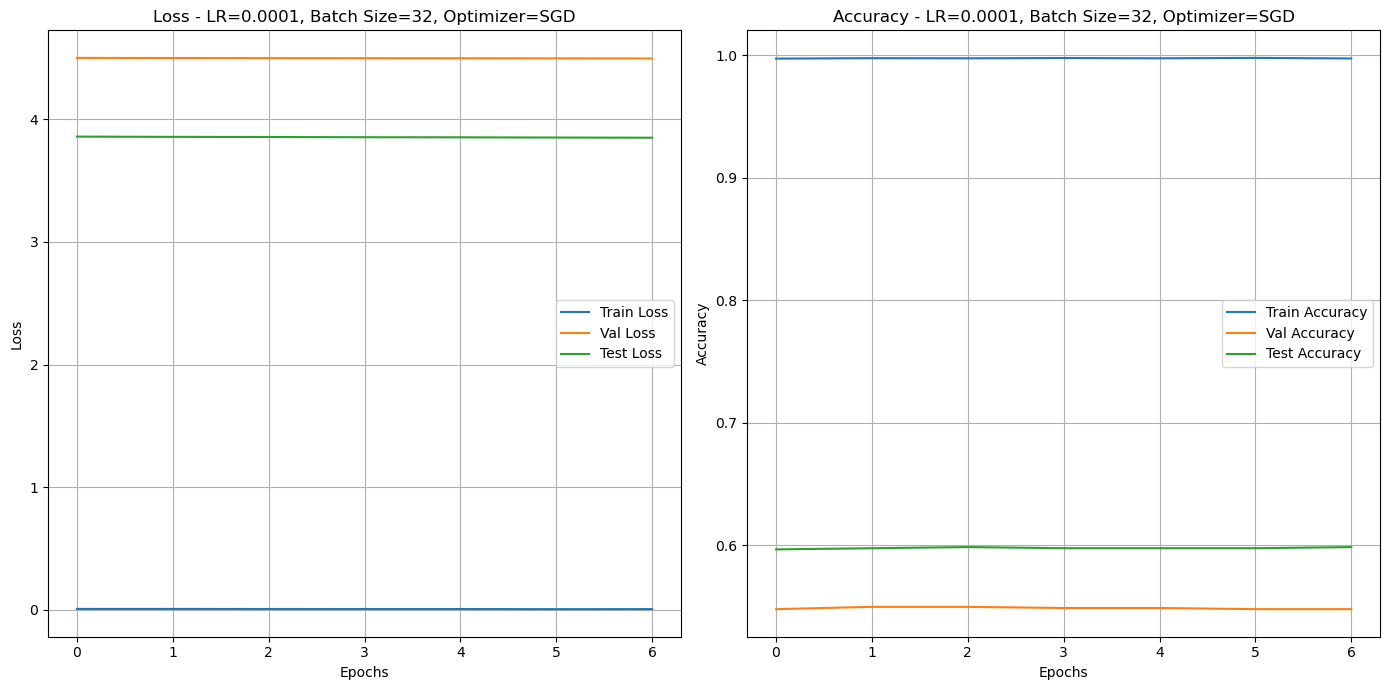


Training with parameters: Learning Rate=0.0001, Batch Size=32, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0059, Train Accuracy: 0.9979
Test Loss: 3.8523, Test Accuracy: 0.5947
Val Loss: 4.4903, Val Accuracy: 0.5497
Model saved.

Epoch 2/100
Train Loss: 0.0060, Train Accuracy: 0.9974
Test Loss: 3.8474, Test Accuracy: 0.5976
Val Loss: 4.4797, Val Accuracy: 0.5507
Model saved.

Epoch 3/100
Train Loss: 0.0056, Train Accuracy: 0.9975
Test Loss: 3.8453, Test Accuracy: 0.5994
Val Loss: 4.4760, Val Accuracy: 0.5507
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0046, Train Accuracy: 0.9979
Test Loss: 3.8509, Test Accuracy: 0.5985
Val Loss: 4.4789, Val Accuracy: 0.5488
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0050, Train Accuracy: 0.9972
Test Loss: 3.8512, Test Accuracy: 0.5976
Val Loss: 4.4785, Val Accuracy: 0.5488
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0050, Train Accuracy: 0.9975
Test Loss: 3.8518, Test Accuracy

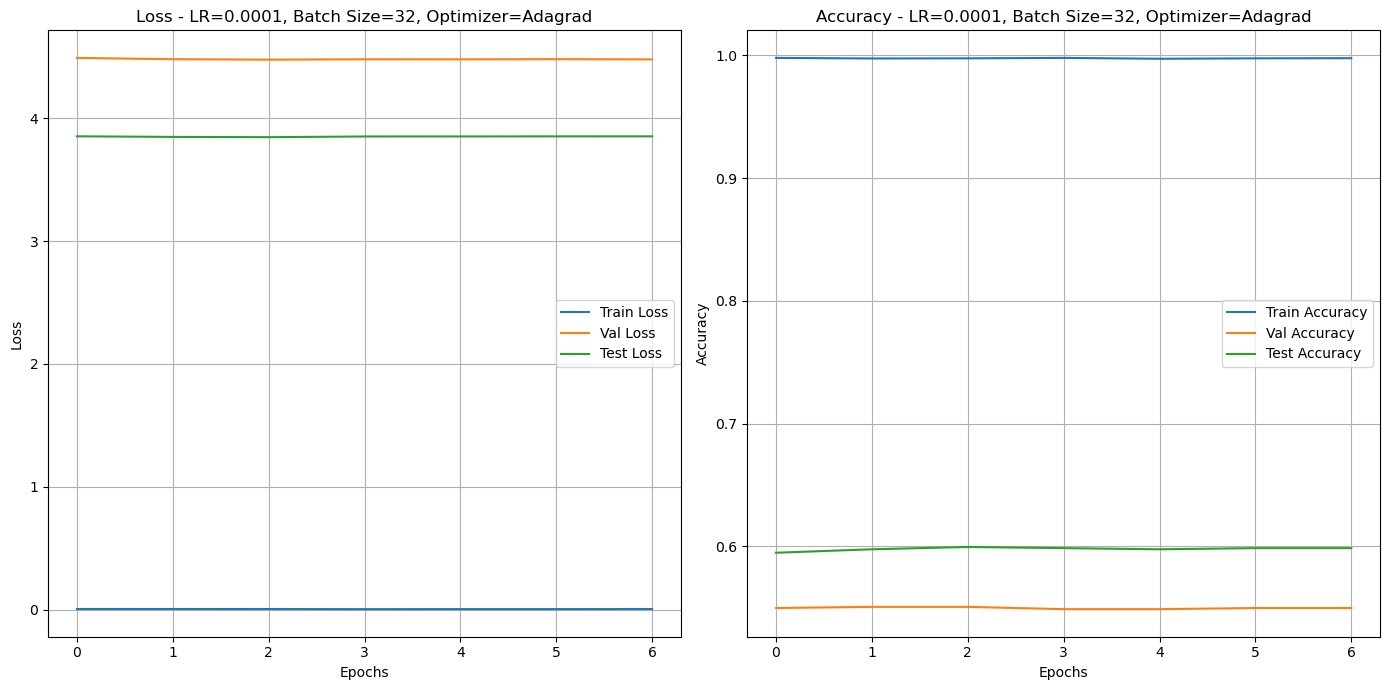


Training with parameters: Learning Rate=0.0001, Batch Size=32, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0047, Train Accuracy: 0.9973
Test Loss: 3.8683, Test Accuracy: 0.6013
Val Loss: 4.4902, Val Accuracy: 0.5553
Model saved.

Epoch 2/100
Train Loss: 0.0053, Train Accuracy: 0.9979
Test Loss: 3.9528, Test Accuracy: 0.5929
Val Loss: 4.4944, Val Accuracy: 0.5582
Model saved.

Epoch 3/100
Train Loss: 0.0055, Train Accuracy: 0.9972
Test Loss: 3.9485, Test Accuracy: 0.6041
Val Loss: 4.5606, Val Accuracy: 0.5450
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0070, Train Accuracy: 0.9973
Test Loss: 4.0281, Test Accuracy: 0.5947
Val Loss: 4.5723, Val Accuracy: 0.5535
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0077, Train Accuracy: 0.9973
Test Loss: 4.0197, Test Accuracy: 0.5854
Val Loss: 4.5770, Val Accuracy: 0.5450
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.0060, Train Accuracy: 0.9966
Test Loss: 4.0562, Test Accuracy: 0

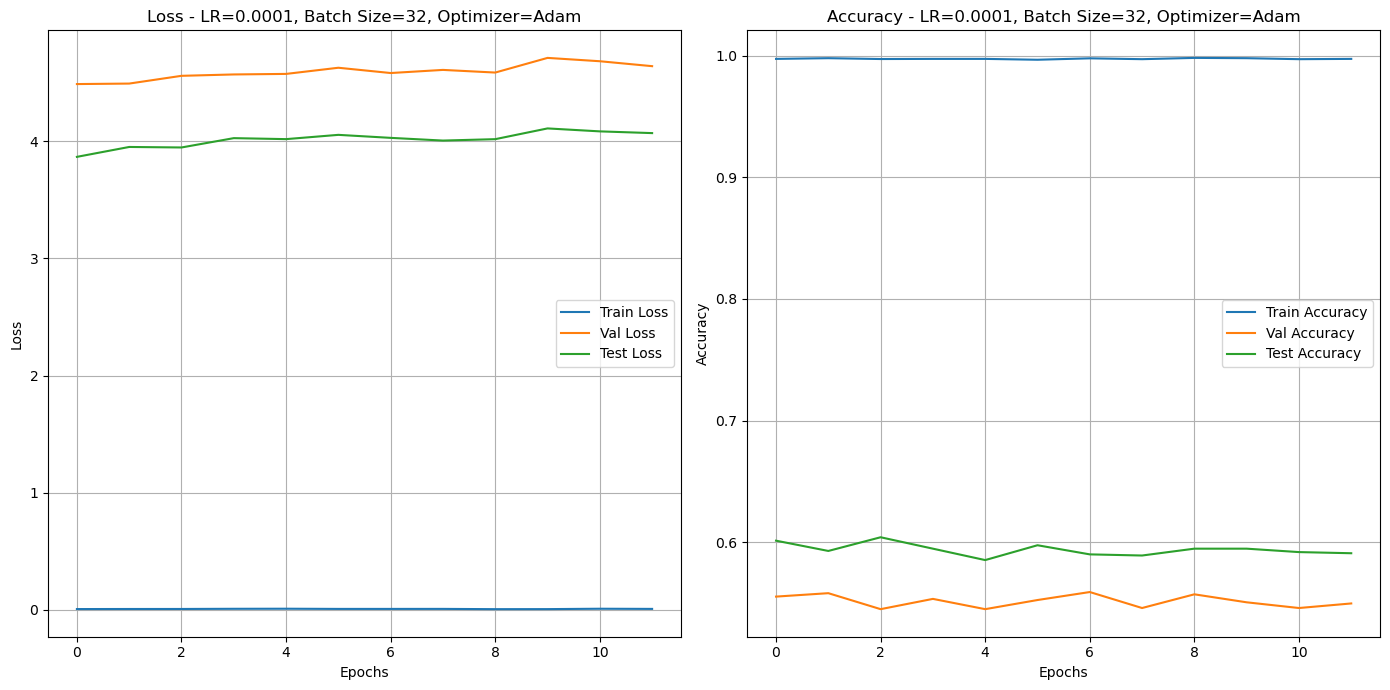


Training with parameters: Learning Rate=0.0001, Batch Size=32, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0067, Train Accuracy: 0.9975
Test Loss: 4.1028, Test Accuracy: 0.5844
Val Loss: 4.6553, Val Accuracy: 0.5553
Model saved.

Epoch 2/100
Train Loss: 0.0054, Train Accuracy: 0.9975
Test Loss: 4.0263, Test Accuracy: 0.6004
Val Loss: 4.6493, Val Accuracy: 0.5563
Model saved.

Epoch 3/100
Train Loss: 0.0057, Train Accuracy: 0.9978
Test Loss: 4.1161, Test Accuracy: 0.6032
Val Loss: 4.6391, Val Accuracy: 0.5638
Model saved.

Epoch 4/100
Train Loss: 0.0049, Train Accuracy: 0.9980
Test Loss: 4.1533, Test Accuracy: 0.6013
Val Loss: 4.6797, Val Accuracy: 0.5582
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0059, Train Accuracy: 0.9979
Test Loss: 4.1427, Test Accuracy: 0.5872
Val Loss: 4.7228, Val Accuracy: 0.5535
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0063, Train Accuracy: 0.9975
Test Loss: 4.0860, Test Accuracy: 0.5947
Val Los

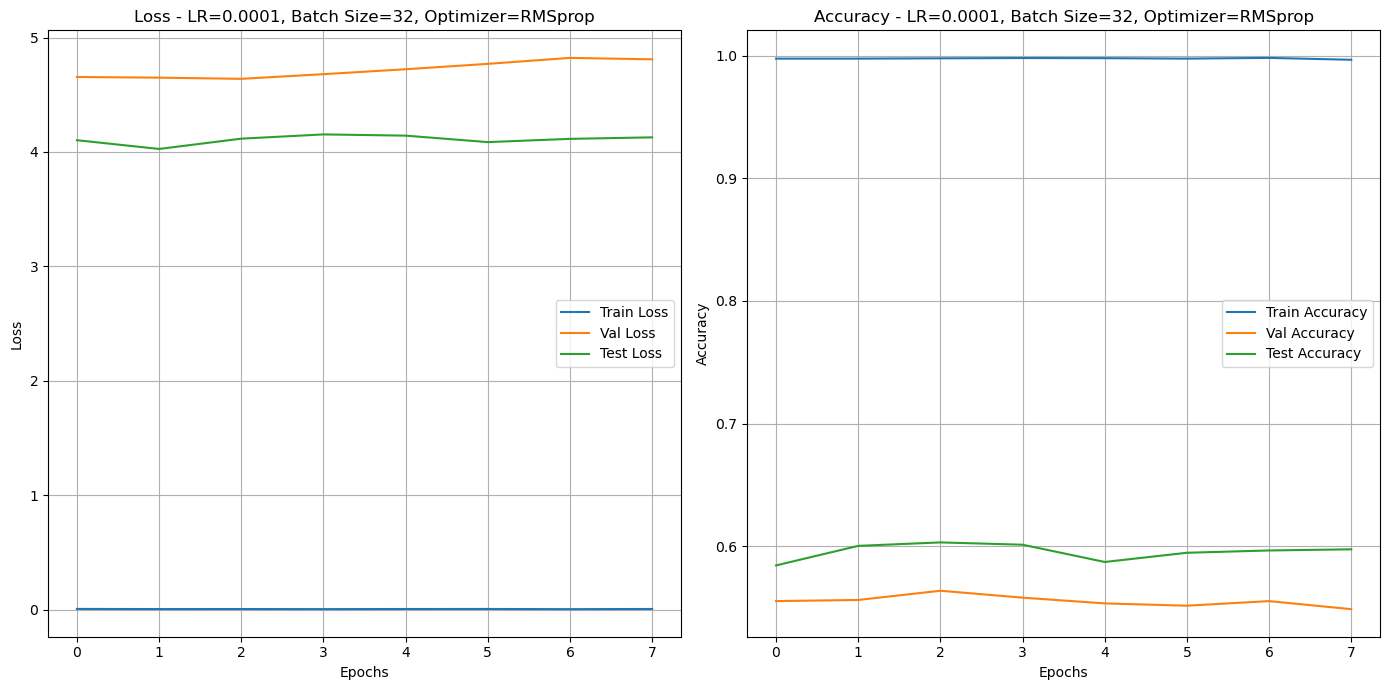


Training with parameters: Learning Rate=0.0001, Batch Size=64, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0046, Train Accuracy: 0.9981
Test Loss: 4.1711, Test Accuracy: 0.5985
Val Loss: 4.8205, Val Accuracy: 0.5488
Model saved.

Epoch 2/100
Train Loss: 0.0054, Train Accuracy: 0.9975
Test Loss: 4.1715, Test Accuracy: 0.5985
Val Loss: 4.8204, Val Accuracy: 0.5488
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0044, Train Accuracy: 0.9979
Test Loss: 4.1722, Test Accuracy: 0.5966
Val Loss: 4.8202, Val Accuracy: 0.5488
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0052, Train Accuracy: 0.9977
Test Loss: 4.1729, Test Accuracy: 0.5966
Val Loss: 4.8201, Val Accuracy: 0.5488
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0048, Train Accuracy: 0.9982
Test Loss: 4.1742, Test Accuracy: 0.5966
Val Loss: 4.8199, Val Accuracy: 0.5488
No improvement for 4 epochs.

Epoch 6/100
Train Loss: 0.0043, Train Accuracy: 0.9979
Test Loss: 4.1751, T

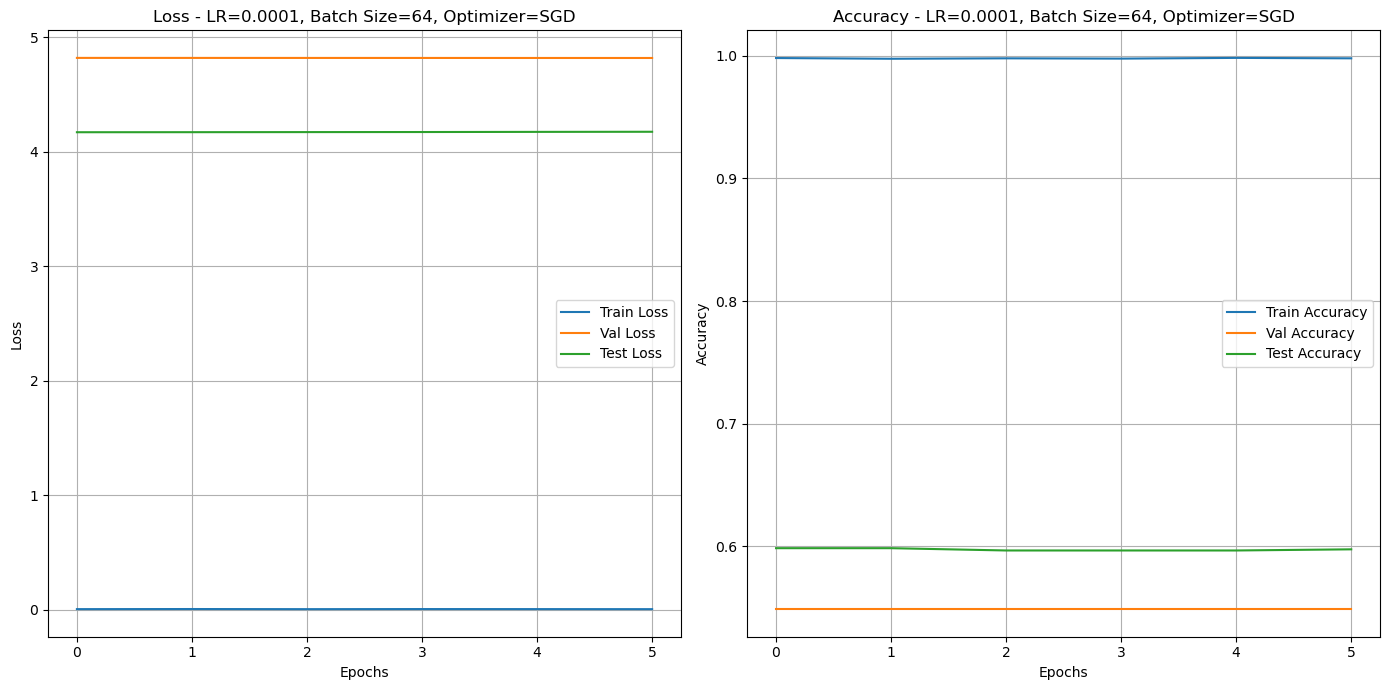


Training with parameters: Learning Rate=0.0001, Batch Size=64, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0042, Train Accuracy: 0.9981
Test Loss: 4.1862, Test Accuracy: 0.5976
Val Loss: 4.8420, Val Accuracy: 0.5469
Model saved.

Epoch 2/100
Train Loss: 0.0041, Train Accuracy: 0.9980
Test Loss: 4.1898, Test Accuracy: 0.5966
Val Loss: 4.8449, Val Accuracy: 0.5488
Model saved.

Epoch 3/100
Train Loss: 0.0050, Train Accuracy: 0.9981
Test Loss: 4.1926, Test Accuracy: 0.5947
Val Loss: 4.8474, Val Accuracy: 0.5488
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0037, Train Accuracy: 0.9980
Test Loss: 4.1911, Test Accuracy: 0.5947
Val Loss: 4.8508, Val Accuracy: 0.5488
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.0041, Train Accuracy: 0.9979
Test Loss: 4.1901, Test Accuracy: 0.5947
Val Loss: 4.8504, Val Accuracy: 0.5497
Model saved.

Epoch 6/100
Train Loss: 0.0050, Train Accuracy: 0.9977
Test Loss: 4.1908, Test Accuracy: 0.5957
Val Los

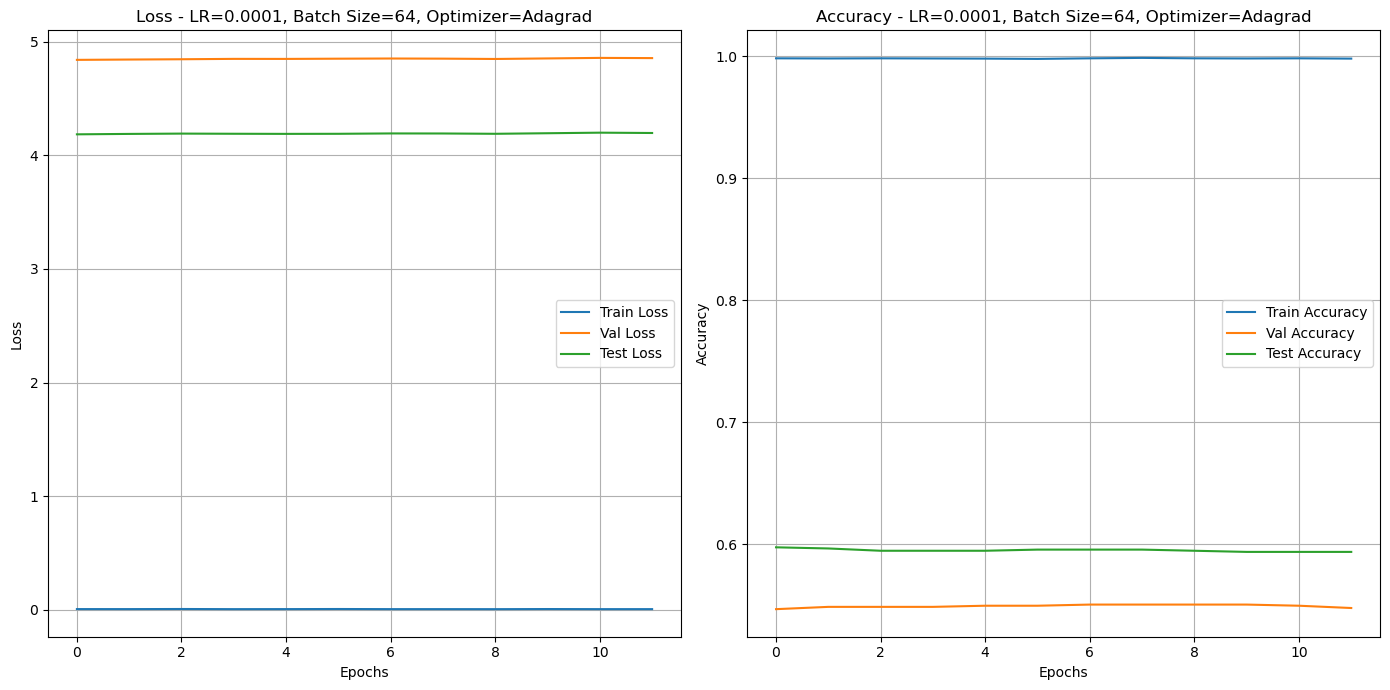


Training with parameters: Learning Rate=0.0001, Batch Size=64, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0062, Train Accuracy: 0.9968
Test Loss: 4.1690, Test Accuracy: 0.6004
Val Loss: 4.8406, Val Accuracy: 0.5478
Model saved.

Epoch 2/100
Train Loss: 0.0038, Train Accuracy: 0.9980
Test Loss: 4.2074, Test Accuracy: 0.5901
Val Loss: 4.8465, Val Accuracy: 0.5469
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0053, Train Accuracy: 0.9975
Test Loss: 4.1945, Test Accuracy: 0.5976
Val Loss: 4.8285, Val Accuracy: 0.5450
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0049, Train Accuracy: 0.9977
Test Loss: 4.1316, Test Accuracy: 0.5938
Val Loss: 4.8020, Val Accuracy: 0.5469
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0040, Train Accuracy: 0.9979
Test Loss: 4.3042, Test Accuracy: 0.5797
Val Loss: 4.8207, Val Accuracy: 0.5478
No improvement for 4 epochs.

Epoch 6/100
Train Loss: 0.0053, Train Accuracy: 0.9974
Test Loss: 4.1969, 

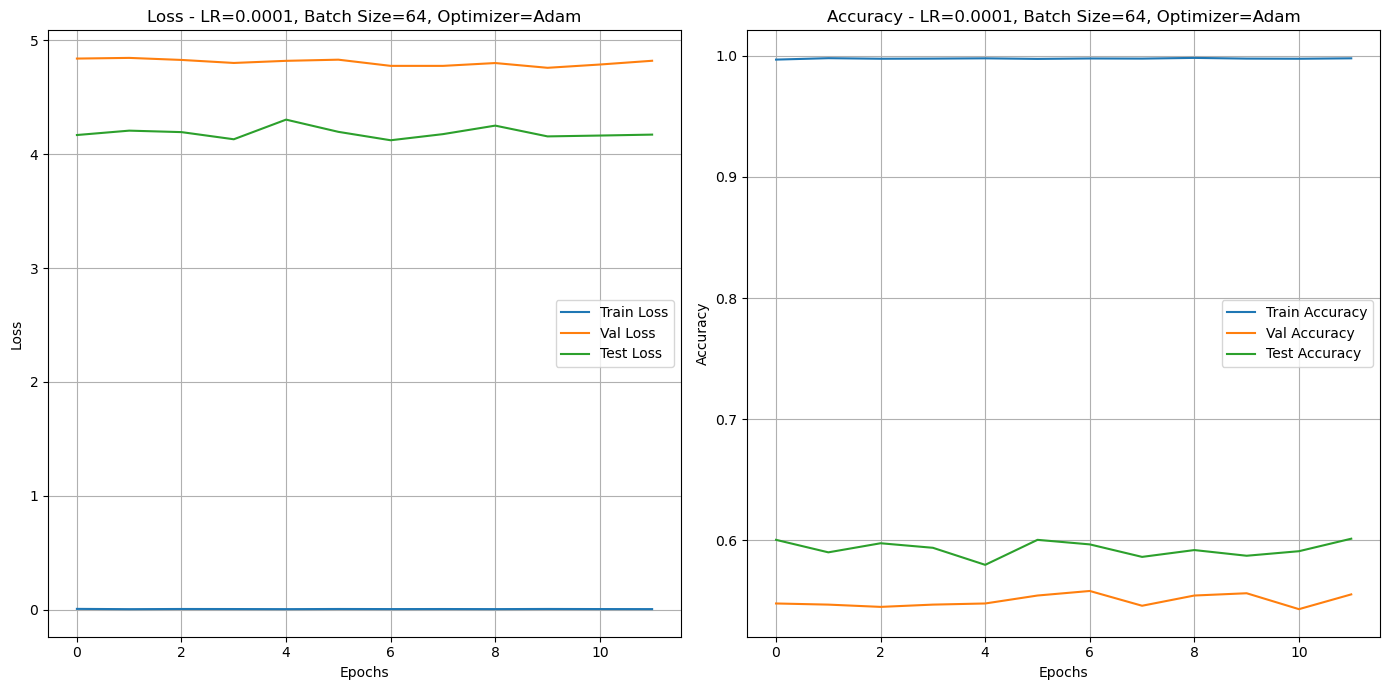


Training with parameters: Learning Rate=0.0001, Batch Size=64, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0055, Train Accuracy: 0.9975
Test Loss: 4.1680, Test Accuracy: 0.5872
Val Loss: 4.7861, Val Accuracy: 0.5525
Model saved.

Epoch 2/100
Train Loss: 0.0045, Train Accuracy: 0.9978
Test Loss: 4.1743, Test Accuracy: 0.5966
Val Loss: 4.8267, Val Accuracy: 0.5507
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0043, Train Accuracy: 0.9981
Test Loss: 4.2300, Test Accuracy: 0.5835
Val Loss: 4.8036, Val Accuracy: 0.5497
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0043, Train Accuracy: 0.9982
Test Loss: 4.1594, Test Accuracy: 0.5929
Val Loss: 4.7758, Val Accuracy: 0.5553
Model saved.

Epoch 5/100
Train Loss: 0.0056, Train Accuracy: 0.9975
Test Loss: 4.2221, Test Accuracy: 0.5910
Val Loss: 4.7995, Val Accuracy: 0.5507
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.0053, Train Accuracy: 0.9975
Test Loss: 4.1806, Test Accuracy

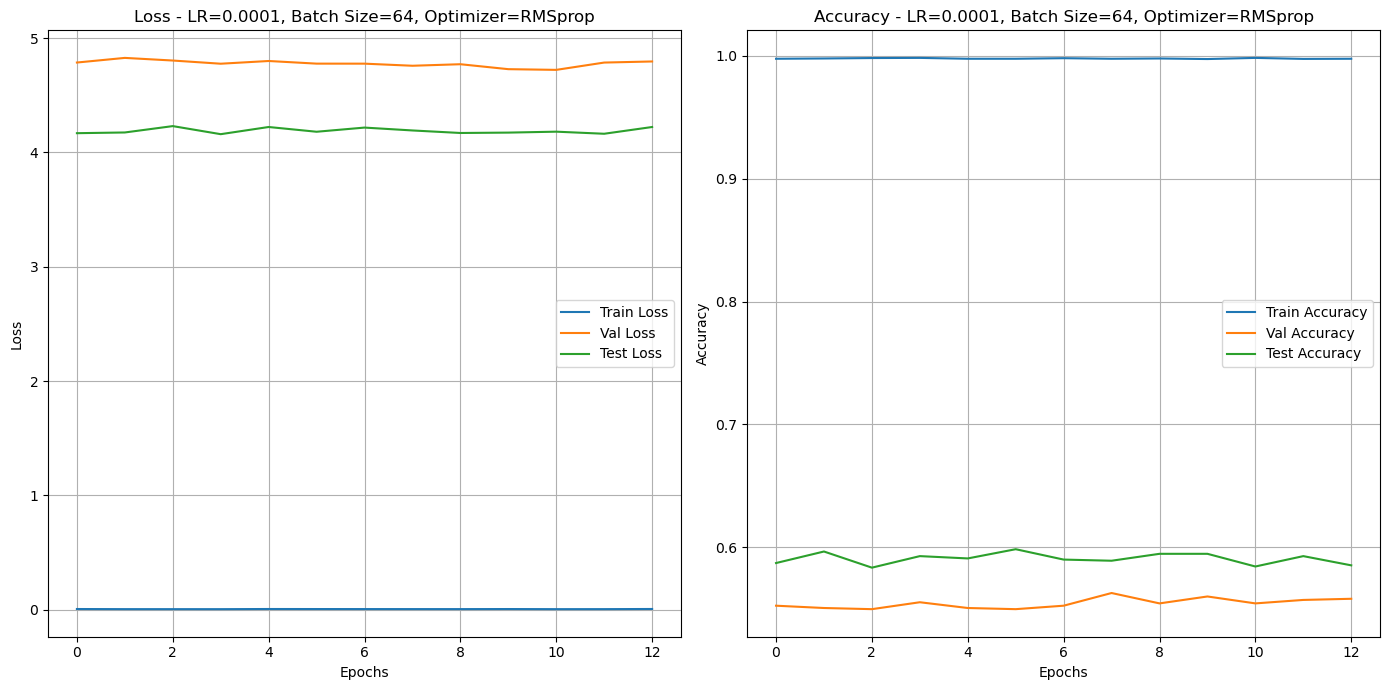


Training with parameters: Learning Rate=0.0001, Batch Size=128, Optimizer=SGD
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0039, Train Accuracy: 0.9980
Test Loss: 4.2801, Test Accuracy: 0.5854
Val Loss: 4.9324, Val Accuracy: 0.5582
Model saved.

Epoch 2/100
Train Loss: 0.0041, Train Accuracy: 0.9979
Test Loss: 4.2802, Test Accuracy: 0.5854
Val Loss: 4.9325, Val Accuracy: 0.5582
No improvement for 1 epochs.

Epoch 3/100
Train Loss: 0.0039, Train Accuracy: 0.9981
Test Loss: 4.2804, Test Accuracy: 0.5854
Val Loss: 4.9327, Val Accuracy: 0.5582
No improvement for 2 epochs.

Epoch 4/100
Train Loss: 0.0040, Train Accuracy: 0.9982
Test Loss: 4.2804, Test Accuracy: 0.5854
Val Loss: 4.9328, Val Accuracy: 0.5582
No improvement for 3 epochs.

Epoch 5/100
Train Loss: 0.0030, Train Accuracy: 0.9986
Test Loss: 4.2804, Test Accuracy: 0.5854
Val Loss: 4.9328, Val Accuracy: 0.5582
No improvement for 4 epochs.

Epoch 6/100
Train Loss: 0.0037, Train Accuracy: 0.9979
Test Loss: 4.2809, 

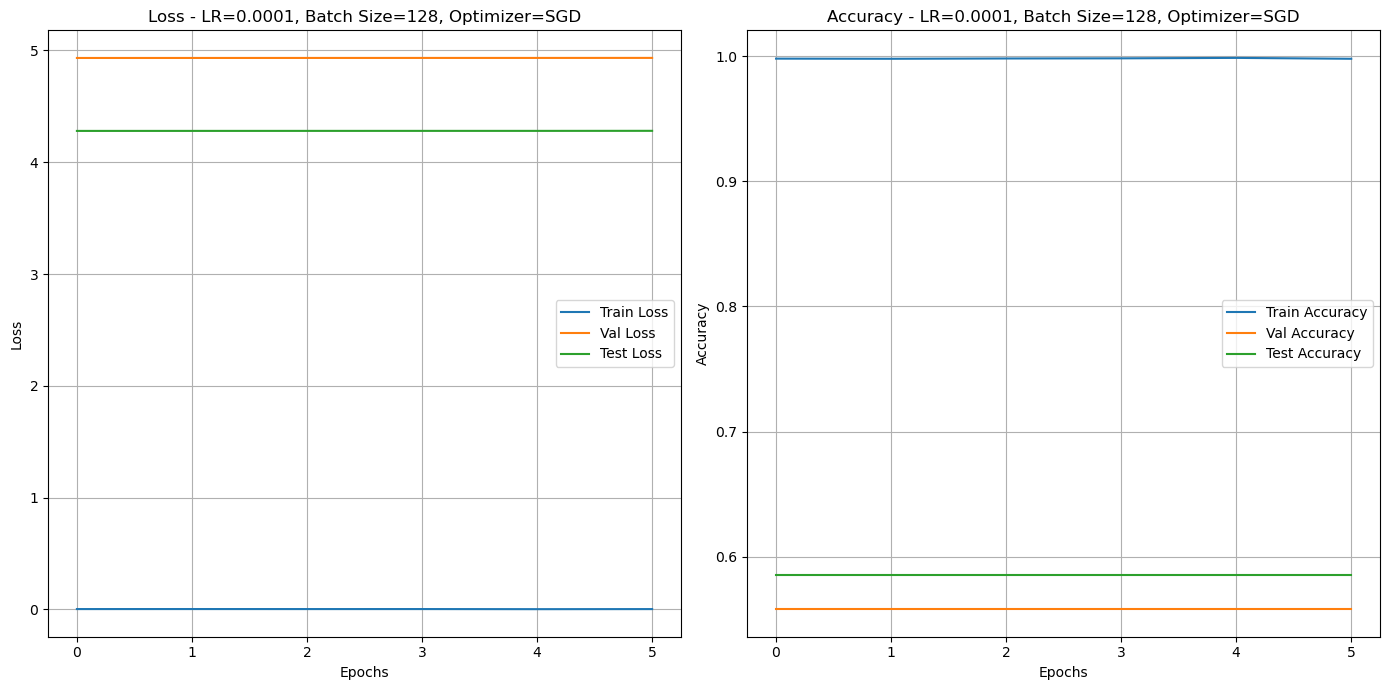


Training with parameters: Learning Rate=0.0001, Batch Size=128, Optimizer=Adagrad
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0044, Train Accuracy: 0.9975
Test Loss: 4.2547, Test Accuracy: 0.5872
Val Loss: 4.9327, Val Accuracy: 0.5572
Model saved.

Epoch 2/100
Train Loss: 0.0041, Train Accuracy: 0.9972
Test Loss: 4.2516, Test Accuracy: 0.5872
Val Loss: 4.9337, Val Accuracy: 0.5582
Model saved.

Epoch 3/100
Train Loss: 0.0029, Train Accuracy: 0.9984
Test Loss: 4.2437, Test Accuracy: 0.5882
Val Loss: 4.9322, Val Accuracy: 0.5591
Model saved.

Epoch 4/100
Train Loss: 0.0042, Train Accuracy: 0.9973
Test Loss: 4.2600, Test Accuracy: 0.5882
Val Loss: 4.9400, Val Accuracy: 0.5563
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0032, Train Accuracy: 0.9984
Test Loss: 4.2506, Test Accuracy: 0.5872
Val Loss: 4.9341, Val Accuracy: 0.5563
No improvement for 2 epochs.

Epoch 6/100
Train Loss: 0.0039, Train Accuracy: 0.9980
Test Loss: 4.2480, Test Accuracy: 0.5882
Val Lo

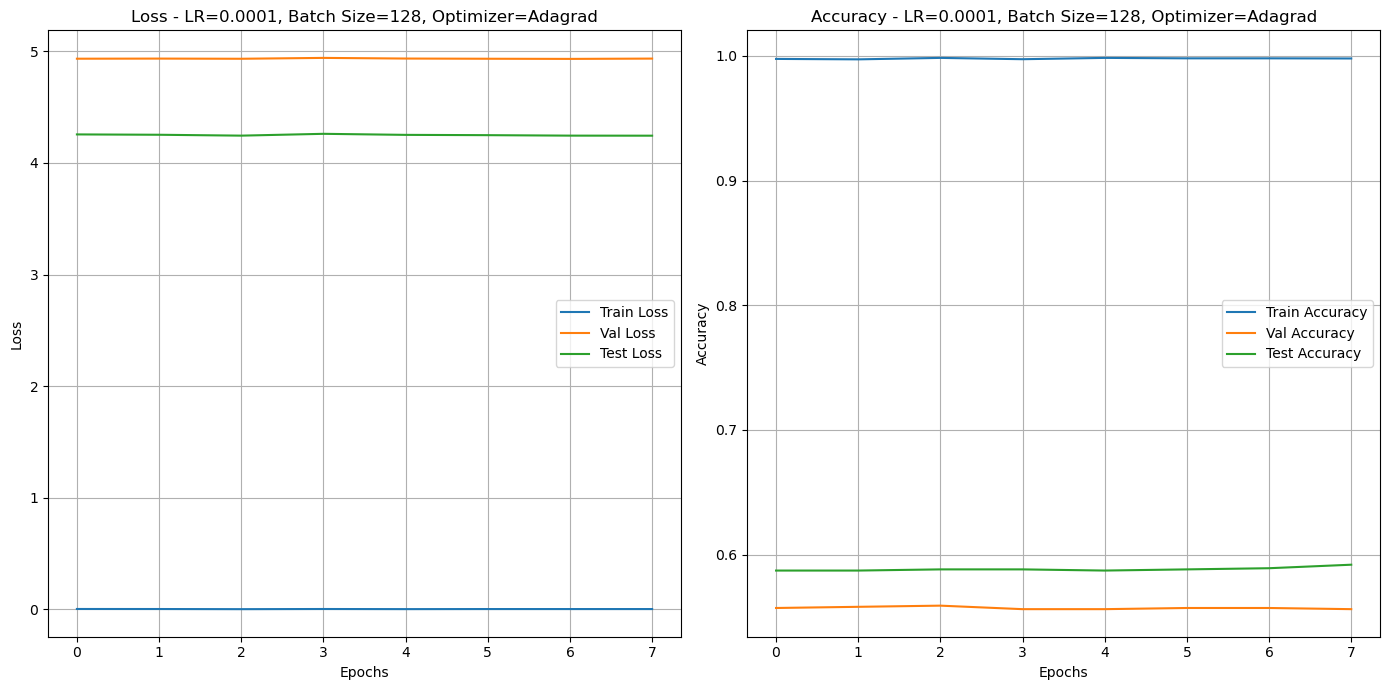


Training with parameters: Learning Rate=0.0001, Batch Size=128, Optimizer=Adam
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0042, Train Accuracy: 0.9980
Test Loss: 4.3803, Test Accuracy: 0.5844
Val Loss: 4.9965, Val Accuracy: 0.5497
Failed to save model to c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt: File c:\Users\En Lih\OneDrive - Nanyang Technological University\Year 4\SC4002 Natural Language Processing\Group Assignment\best_model_last.pt cannot be opened.

Epoch 2/100
Train Loss: 0.0045, Train Accuracy: 0.9979
Test Loss: 4.2880, Test Accuracy: 0.5929
Val Loss: 4.9592, Val Accuracy: 0.5563
Model saved.

Epoch 3/100
Train Loss: 0.0041, Train Accuracy: 0.9979
Test Loss: 4.2573, Test Accuracy: 0.5919
Val Loss: 4.9135, Val Accuracy: 0.5507
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.0045, Train Accuracy: 0.9975
Test Loss: 4.2404, Test Accuracy: 0.5929
Val Loss: 4.

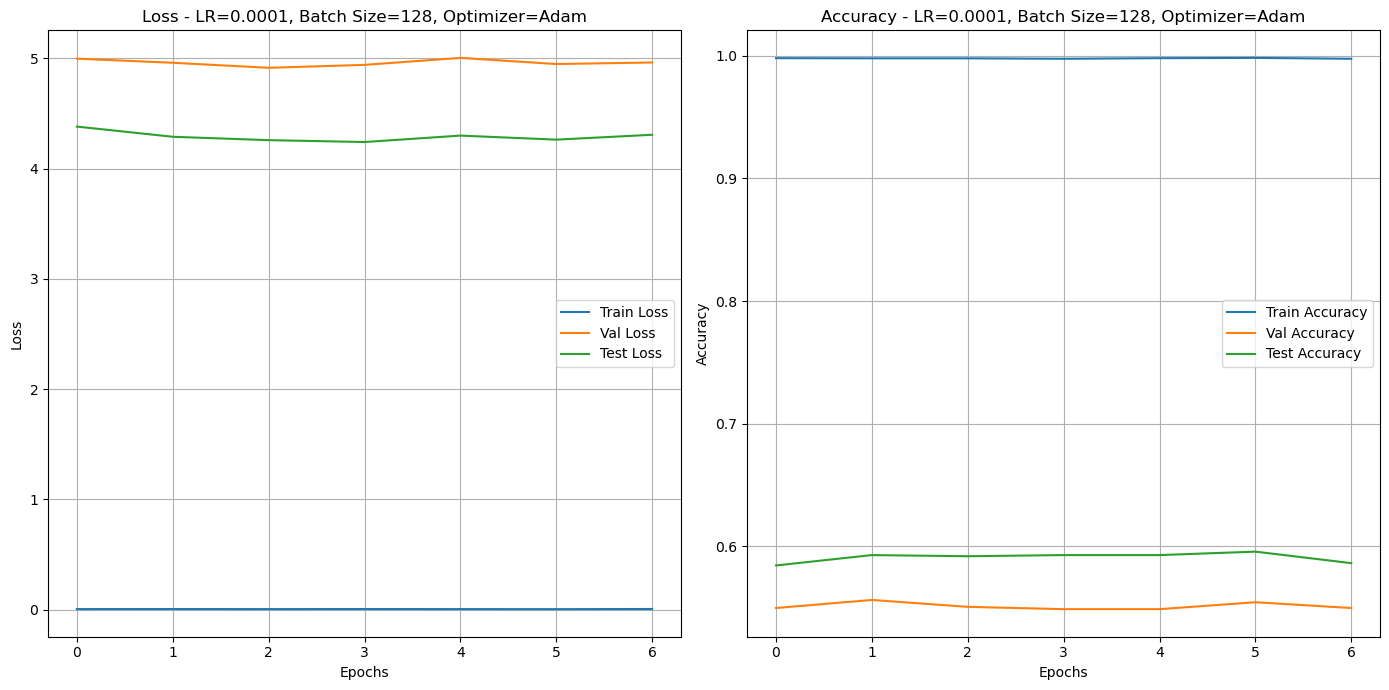


Training with parameters: Learning Rate=0.0001, Batch Size=128, Optimizer=RMSprop
Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.0079, Train Accuracy: 0.9971
Test Loss: 4.3874, Test Accuracy: 0.5807
Val Loss: 4.9915, Val Accuracy: 0.5460
Model saved.

Epoch 2/100
Train Loss: 0.0044, Train Accuracy: 0.9978
Test Loss: 4.2695, Test Accuracy: 0.5929
Val Loss: 4.9402, Val Accuracy: 0.5516
Model saved.

Epoch 3/100
Train Loss: 0.0053, Train Accuracy: 0.9979
Test Loss: 4.3105, Test Accuracy: 0.5835
Val Loss: 4.9463, Val Accuracy: 0.5544
Model saved.

Epoch 4/100
Train Loss: 0.0048, Train Accuracy: 0.9977
Test Loss: 4.3126, Test Accuracy: 0.5919
Val Loss: 4.9360, Val Accuracy: 0.5507
No improvement for 1 epochs.

Epoch 5/100
Train Loss: 0.0049, Train Accuracy: 0.9978
Test Loss: 4.2194, Test Accuracy: 0.5938
Val Loss: 4.9105, Val Accuracy: 0.5553
Model saved.

Epoch 6/100
Train Loss: 0.0040, Train Accuracy: 0.9979
Test Loss: 4.1970, Test Accuracy: 0.5947
Val Loss: 4.8776, Val 

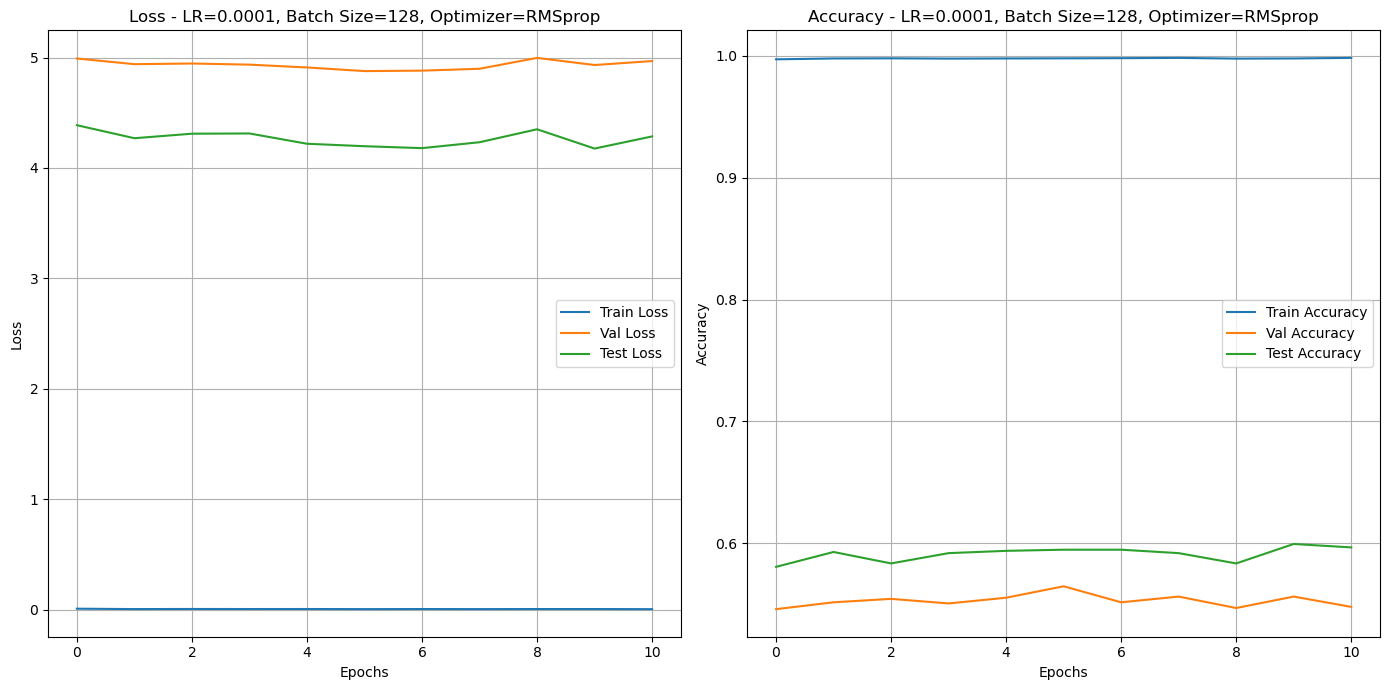


Best Configuration:
{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}
Best Validation Accuracy: 0.6135084427767354


In [34]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [32, 64, 128],
    'optimizer': ['SGD', 'Adagrad', 'Adam', 'RMSprop']
}

# Adjusted hyperparameters
hidden_dim = 128  # Reduced hidden dimension
output_dim = 2    # Binary classification (positive/negative sentiment)

# Initialising RNN Model (last hidden layer) and model's parameters
pooling_strategy = 'last'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
criterion = nn.CrossEntropyLoss()

# Perform grid search
results, best_config = grid_search_train_and_evaluate(
    param_grid=param_grid,
    model=model,
    criterion=criterion,
    pooling_strategy=pooling_strategy,
    epochs=100,
    early_stopping_patience=5
)

Based on the GridSearchCV, the best configuration for the RNN model is when the ```learning rate = 0.001```, ```batch_size = 32```, ```optimizer = Adam```

## Initialize parameters and prepare DataLoaders

In [47]:
# Adjusted hyperparameters based on GridSearch results
batch_size = 32
hidden_dim = 128  # Reduced hidden dimension
output_dim = 2    # Binary classification (positive/negative sentiment)
learning_rate = 0.001
weight_decay = 1e-4
epochs = 100

In [ ]:
# Data loaders with collate function
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

## 1. Default RNN Model (Last Hidden Layer)


The RNN Model directly uses the last hidden state of the RNN as the representation of the sequence, with the assumption that it captures the overall meaning of the sequence

### Instantiate Model, Optimiser, and Loss Function

In [91]:
# Initialising RNN Model (last hidden layer) and model's parameters
pooling_strategy = 'last'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [92]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    early_stopping_patience=5,
    pooling_strategy=pooling_strategy,
    load_best_model=True)

Training with pooling strategy: last

Epoch 1/100
Train Loss: 0.6998, Train Accuracy: 0.5252
Test Loss: 0.6835, Test Accuracy: 0.5582
Val Loss: 0.6821, Val Accuracy: 0.5638
Model saved.

Epoch 2/100
Train Loss: 0.6527, Train Accuracy: 0.6234
Test Loss: 0.6522, Test Accuracy: 0.6229
Val Loss: 0.6793, Val Accuracy: 0.5976
Model saved.

Epoch 3/100
Train Loss: 0.6169, Train Accuracy: 0.6628
Test Loss: 0.6860, Test Accuracy: 0.6126
Val Loss: 0.6988, Val Accuracy: 0.5947
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.5887, Train Accuracy: 0.6967
Test Loss: 0.6626, Test Accuracy: 0.6032
Val Loss: 0.6772, Val Accuracy: 0.6088
Model saved.

Epoch 5/100
Train Loss: 0.5780, Train Accuracy: 0.7076
Test Loss: 0.6755, Test Accuracy: 0.5985
Val Loss: 0.6766, Val Accuracy: 0.6079
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.5690, Train Accuracy: 0.7100
Test Loss: 0.6978, Test Accuracy: 0.5797
Val Loss: 0.7125, Val Accuracy: 0.5947
No improvement for 2 epochs.

Epoch 7/100
Train Lo

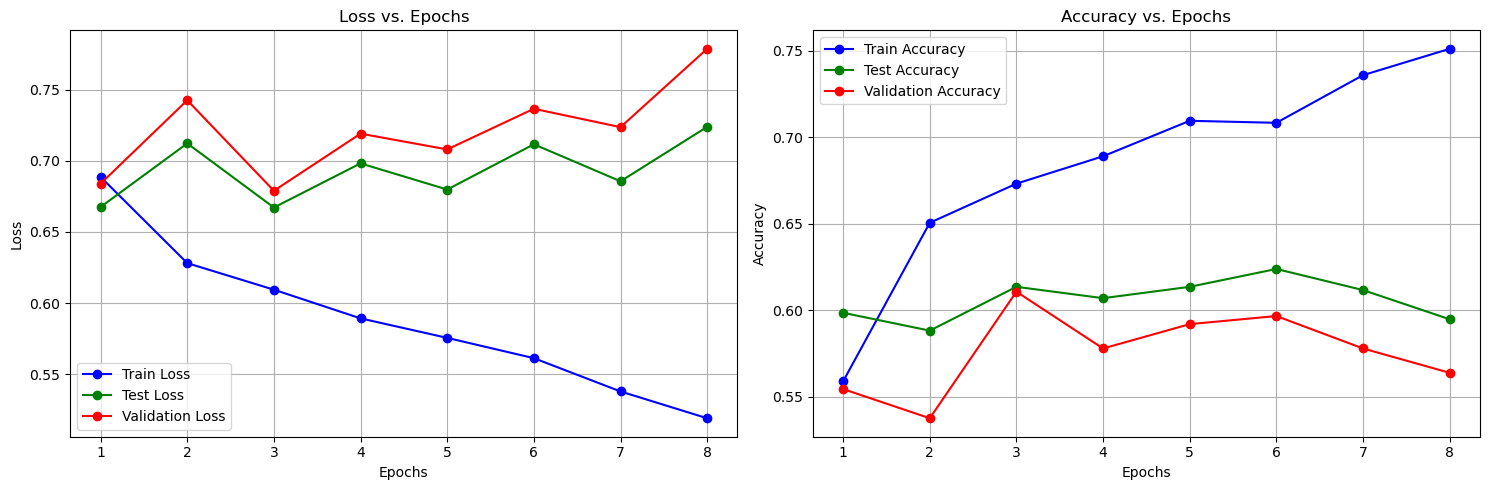

In [70]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [71]:
# Final evaluation on the validation set to compare whether model is correct
last_val_loss, last_val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {last_val_loss:.4f}, Validation Accuracy: {last_val_accuracy:.4f}")

Validation Loss: 0.6789, Validation Accuracy: 0.6107


In [72]:
# Final evaluation on the test set
last_test_loss, last_test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {last_test_loss:.4f}, Test Accuracy: {last_test_accuracy:.4f}")

Test Loss: 0.6672, Test Accuracy: 0.6135


## 2. Maximum Pooling RNN Model

The RNN Model takes the maximum value across all time steps for each feature, focusing on the most prominent feature in the sequence.

In [73]:
# Initialising RNN Model (maximum pooling) and model's parameters
pooling_strategy = 'max'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [74]:
# Train the model with early stopping
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    early_stopping_patience=5,
    pooling_strategy=pooling_strategy,
    load_best_model=True)

Training with pooling strategy: max

Epoch 1/100
Train Loss: 0.7090, Train Accuracy: 0.4966
Test Loss: 0.6931, Test Accuracy: 0.5113
Val Loss: 0.6952, Val Accuracy: 0.4878
Model saved.

Epoch 2/100
Train Loss: 0.6990, Train Accuracy: 0.5005
Test Loss: 0.6938, Test Accuracy: 0.5084
Val Loss: 0.6966, Val Accuracy: 0.4962
Model saved.

Epoch 3/100
Train Loss: 0.6961, Train Accuracy: 0.5021
Test Loss: 0.6921, Test Accuracy: 0.5291
Val Loss: 0.6947, Val Accuracy: 0.4812
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.6967, Train Accuracy: 0.4962
Test Loss: 0.6939, Test Accuracy: 0.4841
Val Loss: 0.6942, Val Accuracy: 0.4906
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.6952, Train Accuracy: 0.5062
Test Loss: 0.6957, Test Accuracy: 0.5000
Val Loss: 0.6968, Val Accuracy: 0.5019
Model saved.

Epoch 6/100
Train Loss: 0.6952, Train Accuracy: 0.4926
Test Loss: 0.6932, Test Accuracy: 0.5094
Val Loss: 0.6939, Val Accuracy: 0.4991
No improvement for 1 epochs.

Epoch 7/100
Train Los

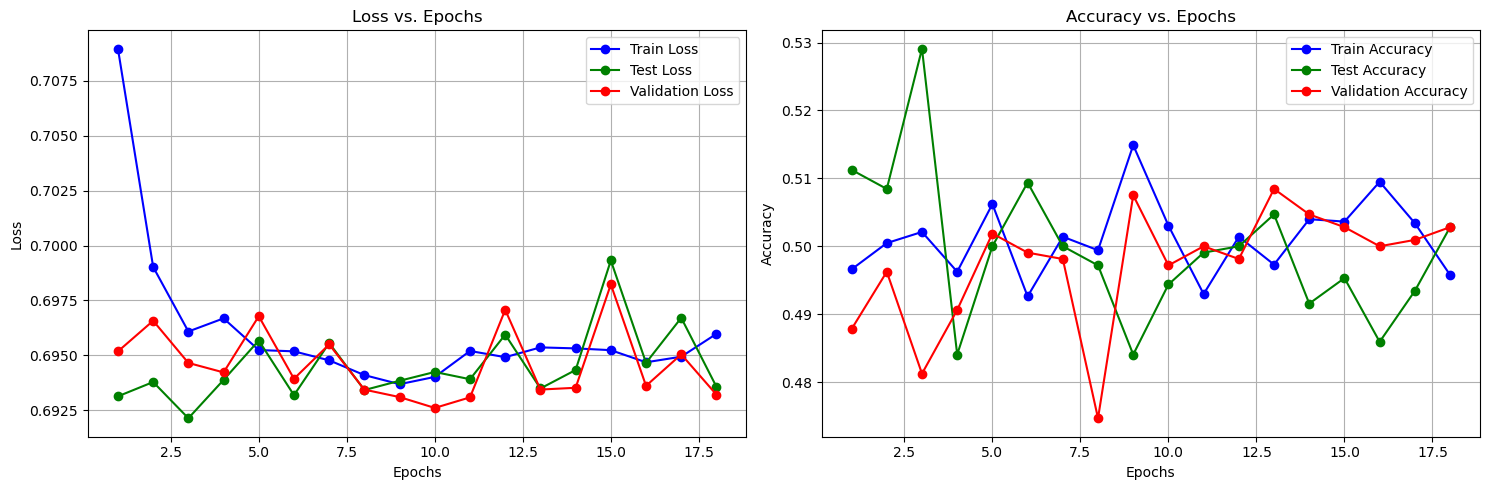

In [75]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [76]:
# Final evaluation on the validation set to compare whether model is correct
max_val_loss, max_val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {max_val_loss:.4f}, Validation Accuracy: {max_val_accuracy:.4f}")

Validation Loss: 0.6934, Validation Accuracy: 0.5084


In [77]:
# Final evaluation on the test set
max_test_loss, max_test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {max_test_loss:.4f}, Test Accuracy: {max_test_accuracy:.4f}")

Test Loss: 0.6935, Test Accuracy: 0.5047


## 3. Mean Pooling RNN Model

The RNN model uses the average of all hidden vectors as the sentence representation by capturing information across the whole sequence.

In [78]:
# Initialising RNN Model (mean pooling layer) and model's parameters
pooling_strategy = 'mean'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [79]:
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    early_stopping_patience=5,
    pooling_strategy=pooling_strategy,
    load_best_model=True)

Training with pooling strategy: mean

Epoch 1/100
Train Loss: 0.6972, Train Accuracy: 0.4993
Test Loss: 0.6920, Test Accuracy: 0.5131
Val Loss: 0.6921, Val Accuracy: 0.5113
Model saved.

Epoch 2/100
Train Loss: 0.6953, Train Accuracy: 0.4962
Test Loss: 0.6922, Test Accuracy: 0.5300
Val Loss: 0.6927, Val Accuracy: 0.5291
Model saved.

Epoch 3/100
Train Loss: 0.6945, Train Accuracy: 0.5009
Test Loss: 0.6931, Test Accuracy: 0.5000
Val Loss: 0.6931, Val Accuracy: 0.4972
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.6948, Train Accuracy: 0.4998
Test Loss: 0.6920, Test Accuracy: 0.5300
Val Loss: 0.6934, Val Accuracy: 0.5000
No improvement for 2 epochs.

Epoch 5/100
Train Loss: 0.6944, Train Accuracy: 0.4950
Test Loss: 0.6916, Test Accuracy: 0.5507
Val Loss: 0.6931, Val Accuracy: 0.4991
No improvement for 3 epochs.

Epoch 6/100
Train Loss: 0.6942, Train Accuracy: 0.4951
Test Loss: 0.6919, Test Accuracy: 0.5356
Val Loss: 0.6927, Val Accuracy: 0.5075
No improvement for 4 epochs.

Epoc

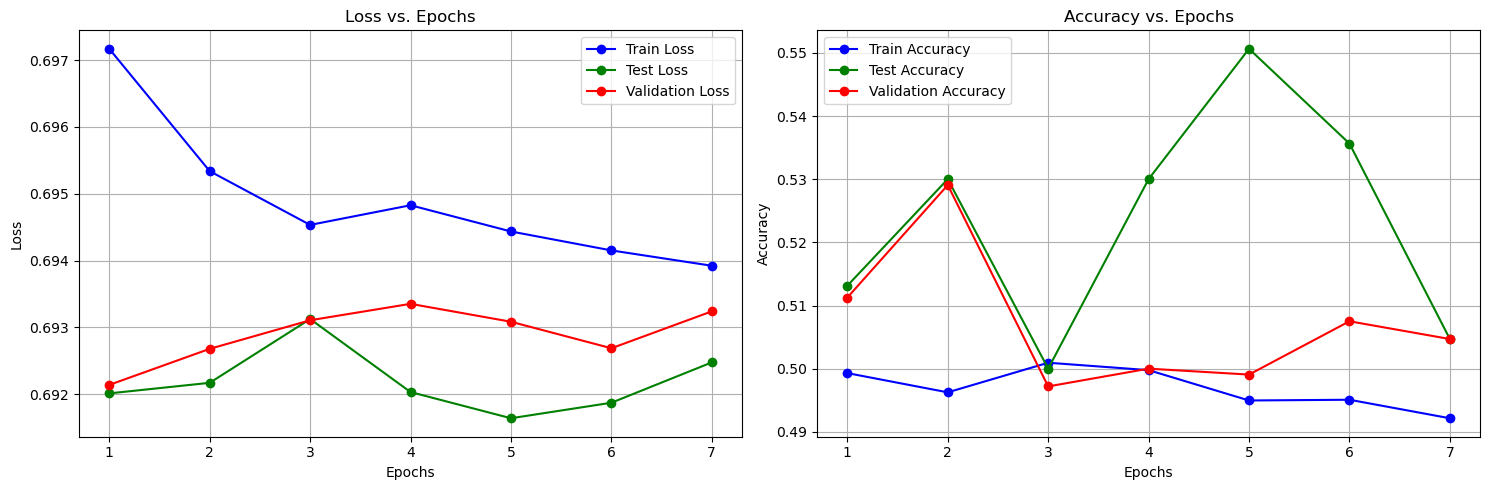

In [80]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [81]:
# Final evaluation on the validation set to compare whether model is correct
mean_val_loss, mean_val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {mean_val_loss:.4f}, Validation Accuracy: {mean_val_accuracy:.4f}")

Validation Loss: 0.6927, Validation Accuracy: 0.5291


In [82]:
# Final evaluation on the test set
mean_test_loss, mean_test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {mean_test_loss:.4f}, Test Accuracy: {mean_test_accuracy:.4f}")

Test Loss: 0.6922, Test Accuracy: 0.5300


## 4. Maximum and Mean Pooling RNN Model

This RNN Model performs max pooling and mean pooling separately on the sequence, subsequently concatenate their outputs to form a single feature vector.

In [83]:
# Initialising RNN Model (maximum pooling) and model's parameters
pooling_strategy = 'max + mean'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [84]:
train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=epochs,
    early_stopping_patience=5,
    pooling_strategy=pooling_strategy,
    load_best_model=True)

Training with pooling strategy: max + mean

Epoch 1/100
Train Loss: 0.6998, Train Accuracy: 0.5048
Test Loss: 0.6946, Test Accuracy: 0.5075
Val Loss: 0.6944, Val Accuracy: 0.4972
Model saved.

Epoch 2/100
Train Loss: 0.6989, Train Accuracy: 0.4912
Test Loss: 0.6934, Test Accuracy: 0.5075
Val Loss: 0.6924, Val Accuracy: 0.5103
Model saved.

Epoch 3/100
Train Loss: 0.6956, Train Accuracy: 0.5030
Test Loss: 0.6939, Test Accuracy: 0.5019
Val Loss: 0.6928, Val Accuracy: 0.5000
No improvement for 1 epochs.

Epoch 4/100
Train Loss: 0.6956, Train Accuracy: 0.4992
Test Loss: 0.6925, Test Accuracy: 0.5169
Val Loss: 0.6918, Val Accuracy: 0.5169
Model saved.

Epoch 5/100
Train Loss: 0.6955, Train Accuracy: 0.4913
Test Loss: 0.6962, Test Accuracy: 0.5000
Val Loss: 0.6949, Val Accuracy: 0.4972
No improvement for 1 epochs.

Epoch 6/100
Train Loss: 0.6948, Train Accuracy: 0.4945
Test Loss: 0.6942, Test Accuracy: 0.5009
Val Loss: 0.6941, Val Accuracy: 0.4972
No improvement for 2 epochs.

Epoch 7/100
Tr

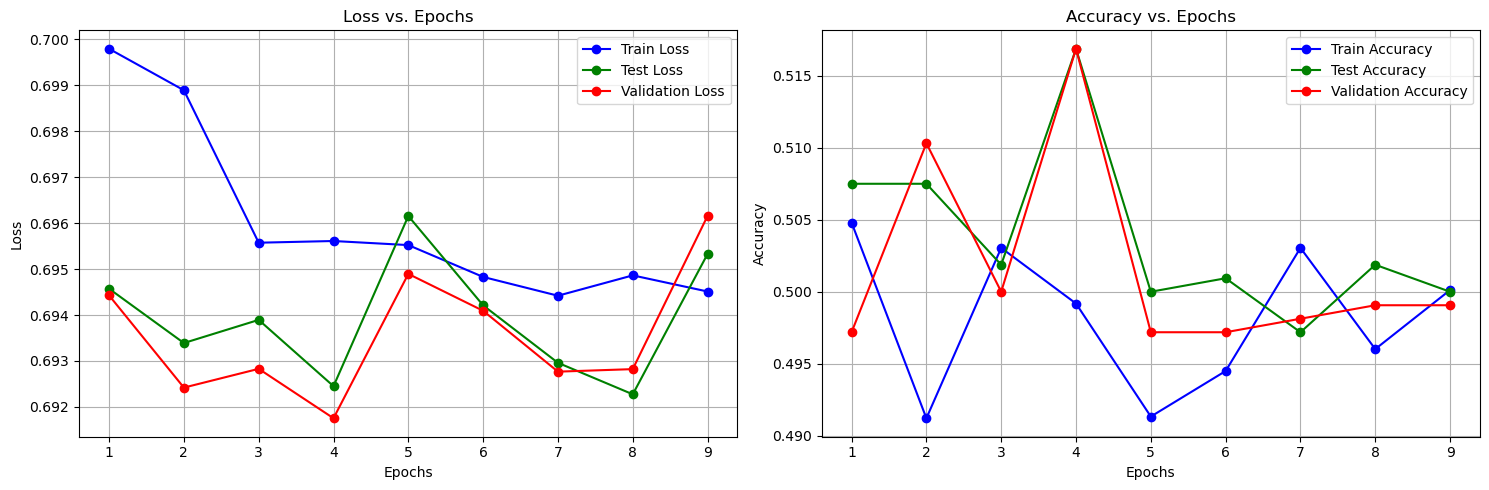

In [85]:
# Plotting Loss and Accuracy against Epochs
plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies, val_losses, val_accuracies)

In [86]:
# Final evaluation on the validation set to compare whether model is correct
mean_max_val_loss, mean_max_val_accuracy = evaluate(model, val_loader, criterion)
print(f"Validation Loss: {mean_max_val_loss:.4f}, Validation Accuracy: {mean_max_val_accuracy:.4f}")

Validation Loss: 0.6918, Validation Accuracy: 0.5169


In [87]:
# Final evaluation on the test set
mean_max_test_loss, mean_max_test_accuracy = evaluate(model, test_loader, criterion)
print(f"Test Loss: {mean_max_test_loss:.4f}, Test Accuracy: {mean_max_test_accuracy:.4f}")

Test Loss: 0.6925, Test Accuracy: 0.5169


# Answers to Question 2: RNN

### 2(a): Report the final configuration of your best model, namely the number of training epochs, learning rate, optimizer, batch size.

In [ ]:
"""

# Adjusted hyperparameters
hidden_dim = 128
output_dim = 2    # Binary classification (positive/negative sentiment)
learning_rate = 0.001
weight_decay = 1e-4
batch_size = 32
epochs = 100

# Best RNN Model (last hidden layer) and model's parameters, optimizer and loss function
pooling_strategy = 'last'
model = SentimentRNN(embedding_matrix, hidden_dim, output_dim, pooling_strategy)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

"""

### 2(b): Report the **accuracy** score on the test set, as well as the **accuracy** score on the validation set for each epoch during training

The data is shown in the cells above when training the model, with visualisations.

### 2(c): RNNs produce a hidden vector for each word, instead of the entire sentence. Which methods have you tried in deriving the final sentence representation to perform sentiment classification? Describe all the strategies you have implemented, together with their accuracy scores on the test set.

#### Final Accuracy Score on Test Set


In [89]:
print(f"RNN Last State - Validation Accuracy: {last_val_accuracy:.4f}, Test Accuracy: {last_test_accuracy:.4f}")
print(f"RNN Maximum Pooling - Validation Accuracy: {max_val_accuracy:.4f}, Test Accuracy: {max_test_accuracy:.4f}")
print(f"RNN Mean Pool - Validation Accuracy: {mean_val_accuracy:.4f}, Test Accuracy: {mean_test_accuracy:.4f}")
print(f"RNN Mean Max Pool - Validation Accuracy: {mean_max_val_accuracy:.4f}, Test Accuracy: {mean_max_test_accuracy:.4f}")

RNN Last State - Validation Accuracy: 0.6107, Test Accuracy: 0.6135
RNN Maximum Pooling - Validation Accuracy: 0.5084, Test Accuracy: 0.5047
RNN Mean Pool - Validation Accuracy: 0.5291, Test Accuracy: 0.5300
RNN Mean Max Pool - Validation Accuracy: 0.5169, Test Accuracy: 0.5169


| Method              | Validation Accuracy | Test Accuracy |
|---------------------|-----------------------|-------------------------|
| RNN Last State      | 0.6107               | 0.6135                |
| RNN Maximum Pooling | 0.5084               | 0.5047                |
| RNN Mean Pooling    | 0.5291              | 0.5300               |
| RNN Mean Max Pooling| 0.5169              | 0.5169                 |

Based on the RNN test accuracies above, we can conclude that the RNN model using the last hidden state is the **best model** with an accuracy of ```63.32%```. It is important to note that handling the OOVs in the pre-trained vectors in the gloVe dataset will improve the model significantly, which will be implemented in Part 3.